In [116]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.data import words_clusters
from src.utils import cluster_search
from src.data.words_clusters import cluster_space, cluster_communism

# other imports
import networkx as nx
from collections import Counter



# DATA LOADING

There are 24140 unique movies in our movies dataset that have ratings given by the found dataset.
The mean number of genres of a given movie is:  5
The mean number of countries of a given movie is:  2
There are now 23432 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


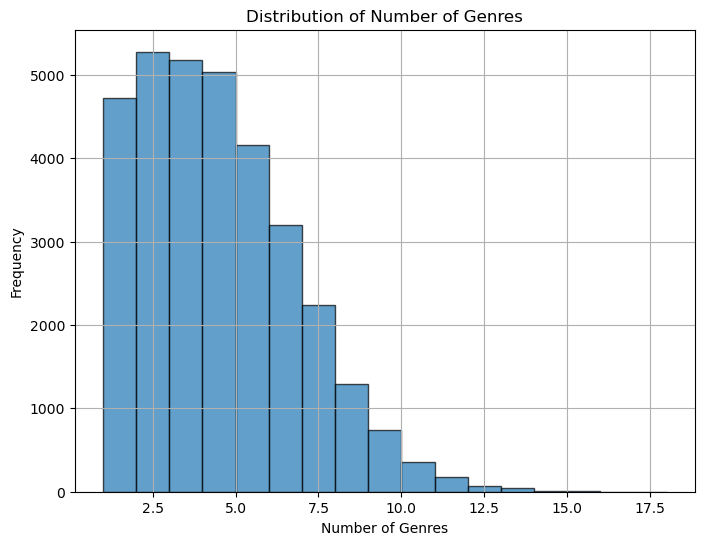

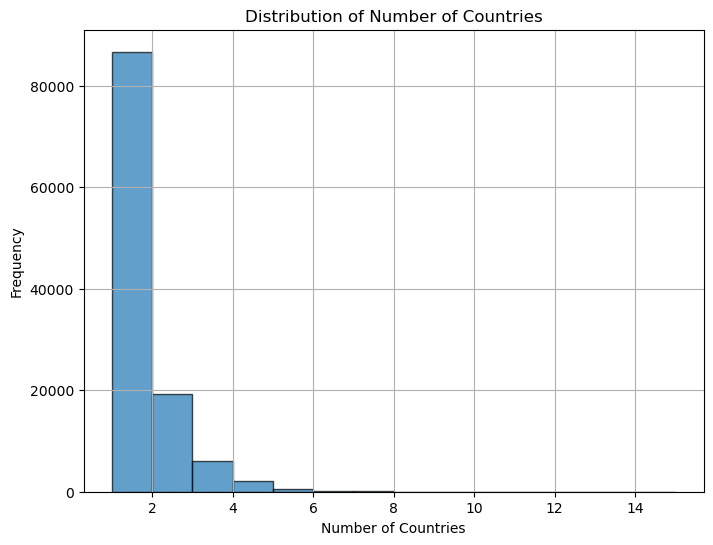

In [2]:
import import_ipynb
import results

df_movies_tmdb_ratings_unique = results.df_movies_tmdb_ratings_unique
df_movies_tmdb_ratings = results.df_movies_tmdb_ratings
df_plots = results.df_plots


# Movies General Basic Statistics

To start the analysis, some general information about the dataframe are retrieved. First, the movies distribution by release date is plotted.

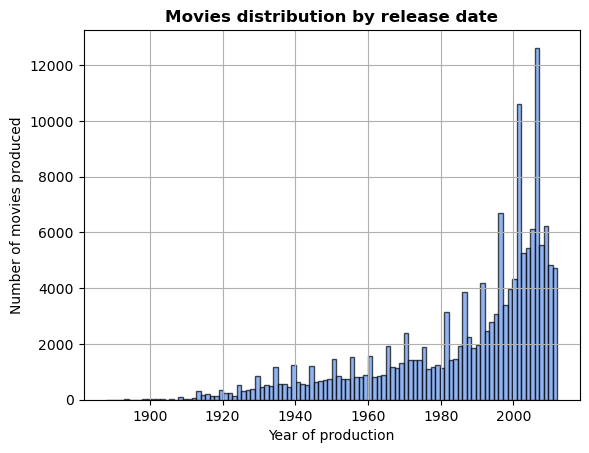

In [3]:
# Movies distribution by release date
plt.figure()
plt.title('Movies distribution by release date', weight='bold')
plt.hist(df_movies_tmdb_ratings['release_date'], bins= 100, edgecolor='black', alpha=0.7, color='cornflowerblue')
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True)
plt.show()

From the above graph, it can be concluded that the number of movies producd each year steeply increases over time.

CHECK IF EXPONENTIAL??

Other numerical parameters are then analysed. In the dataframe, runtime, release date and revenue all present numerical values. The distributions of these attributes are plotted over time.

In [4]:
# Conversion of the revenue column in numerical data
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

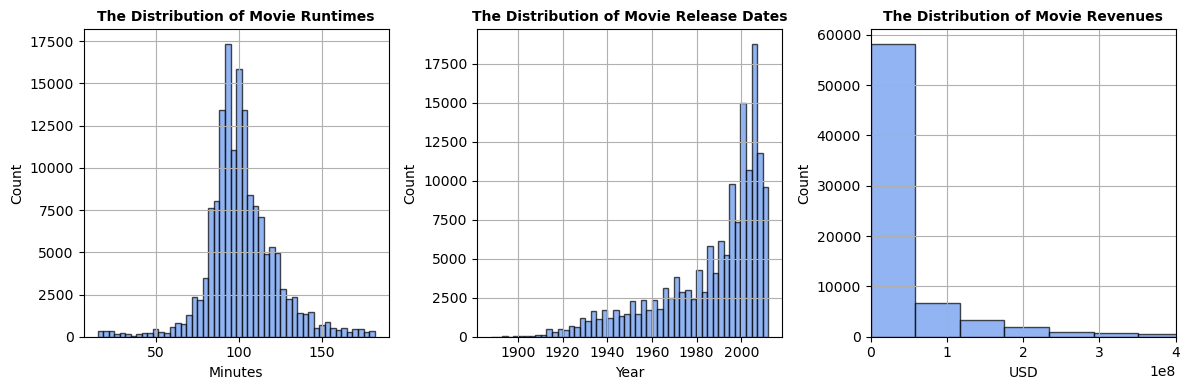

In [5]:
# Standard font for plots
hfont = {'fontname':'sans-serif'}

# Plot the three distributions
fig, ax = plt.subplots(1, 3,figsize= (12,4), sharey = False, sharex = False)

# Labels
quantities = ['runtime', 'release_date', 'revenue']
quantities_x = ['Minutes', 'Year', 'USD']

# Distribution of runtime plot
sbplt = ax[0]
sbplt.hist(df_movies_tmdb_ratings[quantities[0]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Runtimes", **hfont, weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[0], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.grid(True)

# Distribution of release dates plot    
sbplt = ax[1]
sbplt.hist(df_movies_tmdb_ratings[quantities[1]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Release Dates", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[1], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.grid(True)

# Distribution of revenues plot
sbplt = ax[2]
sbplt.hist(df_movies_tmdb_ratings[quantities[2]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Revenues", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[2], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.set_xlim([0, 0.4e9])
sbplt.grid(True)

fig.tight_layout()

From the graphs above, some hypothesis regarding the types of distribution can be done. The shape of the distribution of movie runtime suggest a normal distribution, while the movie revenue looks exponential.

In [6]:
# Testing if the runtime is normally distributed
diagnostic.kstest_normal(df_movies_tmdb_ratings['runtime'].values, dist = 'norm') 

(0.08834432602770224, 0.0009999999999998899)

Although the runtime normality test returns a low p-value, leading us to reject the null hypothesis that the data is normally distributed, the histogram above shows a roughly bell-shaped plot for movie runtime. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >150K entries. Therefore, a Q-Q plot is employed to further assess normality.

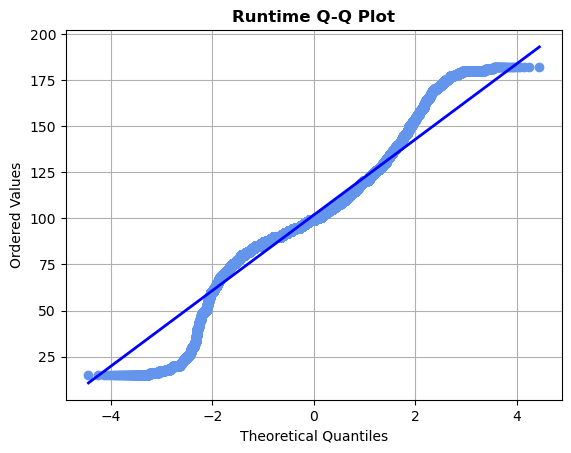

In [7]:
# Setting up the figure
fig, ax = plt.subplots()

# Q-Q plot
res = stats.probplot(df_movies_tmdb_ratings['runtime'].values, dist="norm", plot=ax)

# Line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

# Plot settings 
plt.title("Runtime Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

plt.show()

The steep increases near the plot's edges indicate at runtime values at the extremes of our distribution, there are less values than expected if the plot were to follow a normal trend. The opposite is true for the flatter region of the plot near the center of the theoretical quantiles, indicating we have more runtimes close to the mean of the distribution than expected if there runtimes were normal. So, the runtime data is approximately normal but with a more datapoints more aggregated towards the distribution's mean.

Now, the revenue distribution is tested, to check if it is exponential.

In [8]:
diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['revenue'].dropna().values, dist = 'exp') 

(0.32266192699617324, 0.0009999999999998899)

Similarly to the runtime normality test, the revenue exponential test returns a low p-value, leading us to reject the null hypothesis that the data is exponentially distributed. However, the histogram above shows a roughly power-law plot for movie revenue. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >150K entries. Therefore, a complementary cumulative density function of the revenue data is prepared.

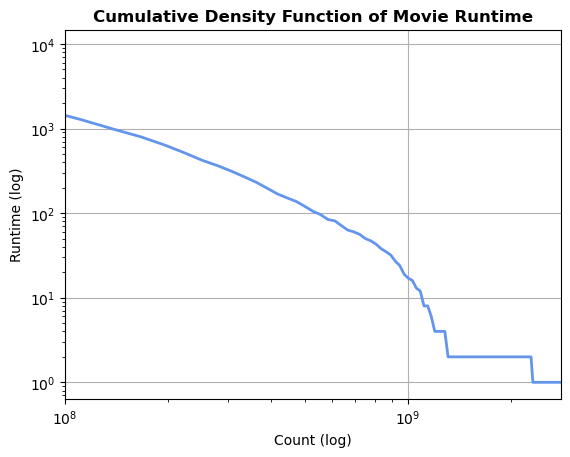

In [9]:
# Setting up the figure
fig, ax = plt.subplots()

# Cumulative density function plot
array_cumulative=plt.hist(df_movies_tmdb_ratings_unique['revenue'].values,bins=100,log=True,cumulative=-1,histtype='step', visible=False)
plt.loglog(array_cumulative[1][1:],array_cumulative[0])

# Line settings
line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

# Plot settings 
plt.title('Cumulative Density Function of Movie Runtime', weight='bold')
plt.xlabel('Count (log)')
plt.ylabel('Runtime (log)')
ax.set_xlim(1e8, max(array_cumulative[1][1:]))
plt.grid(True)
plt.show()


The CCDF of runtime is approximately linearly decreasing, indicative the runtime data to be approximately power law distributed.

Now, possible correlations between these attributes are analysed. First, some plots are used to better visualize relationships.

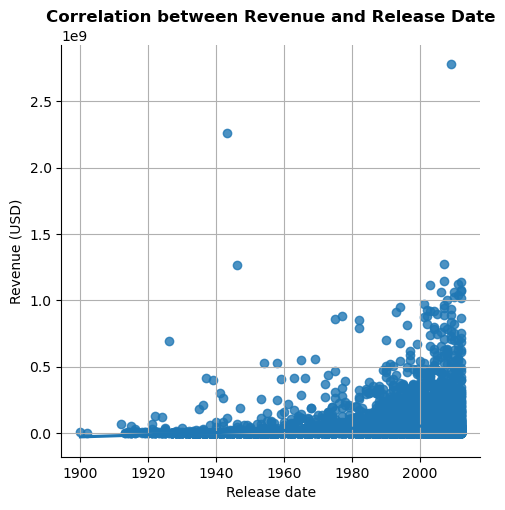

In [10]:
# Scatter-plot to assess possible regressions between release date and revenue
sns.lmplot(x='release_date', y='revenue', data=df_movies_tmdb_ratings_unique)
plt.title('Correlation between Revenue and Release Date', weight='bold')
plt.xlabel("Release date")
plt.ylabel("Revenue (USD)")
plt.grid(True)
plt.show()

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

The same scatter plot is used to assess a possible correlation between runtime and revenue.

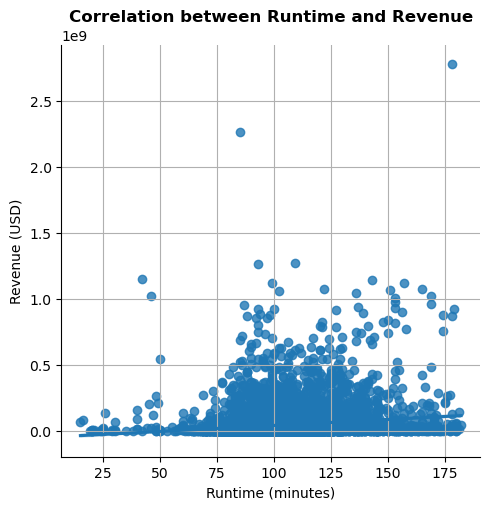

In [11]:
# Scatter-plot to assess possible regressions between runtime and revenue
sns.lmplot(x='runtime',y='revenue', data=df_movies_tmdb_ratings_unique)
plt.title('Correlation between Runtime and Revenue', weight='bold')
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue (USD)")
plt.grid(True)
plt.show()

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

The last combination is analysed: Runtime and Release Date.

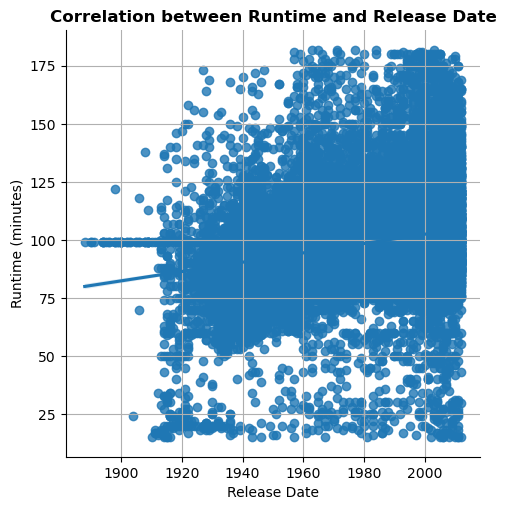

In [12]:
# Scatter-plot to assess possible regressions between runtime and release date
sns.lmplot(x='release_date',y='runtime', data=df_movies_tmdb_ratings_unique)
plt.title('Correlation between Runtime and Release Date', weight='bold')
plt.xlabel("Release Date")
plt.ylabel("Runtime (minutes)")
plt.grid(True)
plt.show()

ADD PEARSON COEFFICIENT TO SEE THE POSITIVE SLOPE, AND MAYBE CHANGE THE COLOR OF THE LINE

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

# Movies Genres Analysis

First, the number of unique genres has to be displayed.

In [13]:
# Printing the number of unique genres
print("The number of different genres is:")
print(len(df_movies_tmdb_ratings['genres'].unique()))
print('\n')

The number of different genres is:
156




The number of different genres is more than 100. For the sake and clarity of the analysis, it is ideal to study a limited number of genres. Therefore, the code below estimates the percentage of the movies that would be considered, if the analysis only included n genres.

In [14]:
# Choosing the number of relevant genres
n = 20

# Selecting the n most relevant genres
genres_counts = df_movies_tmdb_ratings.groupby("genres").size()
genres_counts = genres_counts.sort_values(ascending=False)
genres_top = genres_counts.head(n)

top_genres_count = genres_top.sum()
all_genres_count = genres_counts.sum()

print(f"The top 20 basic genres in the movies dataset account for {round(top_genres_count/all_genres_count * 100)}% of all movie genres.")

# Creating a new dataset, containing only movies from the relevant genres
top_genres = genres_top.index.tolist()
df_movies_tmdb_ratings_genres_filtered = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_genres)].copy()

# Printing the number of movies per genre
print('\n Number of movies per genre:')
print(df_movies_tmdb_ratings_genres_filtered['genres'].value_counts())

The top 20 basic genres in the movies dataset account for 68% of all movie genres.

 Number of movies per genre:
genres
Drama               20529
Comedy               9663
Thriller             8221
Romance Film         7436
World cinema         7140
Action               5803
Crime Fiction        5413
Indie                4791
Action/Adventure     4545
Horror               3973
Adventure            3801
Black-and-white      3528
Romantic drama       3328
Mystery              2876
Fantasy              2639
Period piece         2582
Family Film          2527
Science Fiction      2502
Crime Thriller       2469
Film adaptation      2276
Name: count, dtype: int64


Almost 70% of the total number of movies is described, if the analysis focuses more on 20 "relevant", or most common, genres. Regarding the number of movies per genre, every genre has more than 2'000 movies. Drama, the most present genre, has more than 20'000 movies.

From the loading and cleaning section, it is clear that many movies have more than 1 genre. Having multiple genres can be defined as 'genres complexity' and this feature is studied over time, in order to see the genres complexity distribution based on the release date of the movie.

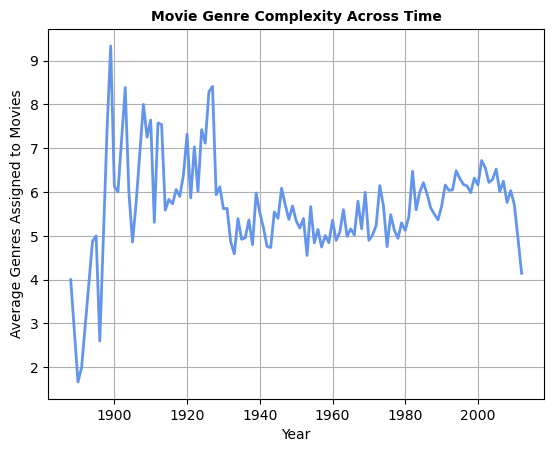

In [15]:
# count the number of genres for each film
unique_genres_count = df_movies_tmdb_ratings.groupby('title')['genres'].nunique()
unique_genres_count = unique_genres_count.to_frame()
unique_genres_count = unique_genres_count.reset_index()

unique_genres_count = unique_genres_count.rename(columns={"genres": "genres_count"}) 
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb_ratings, unique_genres_count, left_on='title', right_on='title')

mean_genres_per_year = df_movies_tmdb_ratings.groupby('release_date')["genres_count"].mean()

# visualizing if more than one genre being given to a film has increased over years
fig, ax = plt.subplots()

mean_genres_per_year.plot(kind='line')  

line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

plt.title("Movie Genre Complexity Across Time", **hfont, weight='bold', fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Average Genres Assigned to Movies", fontsize=10)
plt.grid(True)
plt.show()

It is evident that there are some fluctuations, but the genres complexity does not drastically increase over time. Instead, the first movies, from 1900 to 1930, generally present much higher genres complexity. This figure produced per country and then across time period worldwide and per country would be interesting.

The plot below focus on the distribution of movies in time, divided per genre. Only the most relevant genres are displayed. The objective is to find particular or evident trends to study. Note that, to better visualize the graphs, the y-axis range changes between graphs.

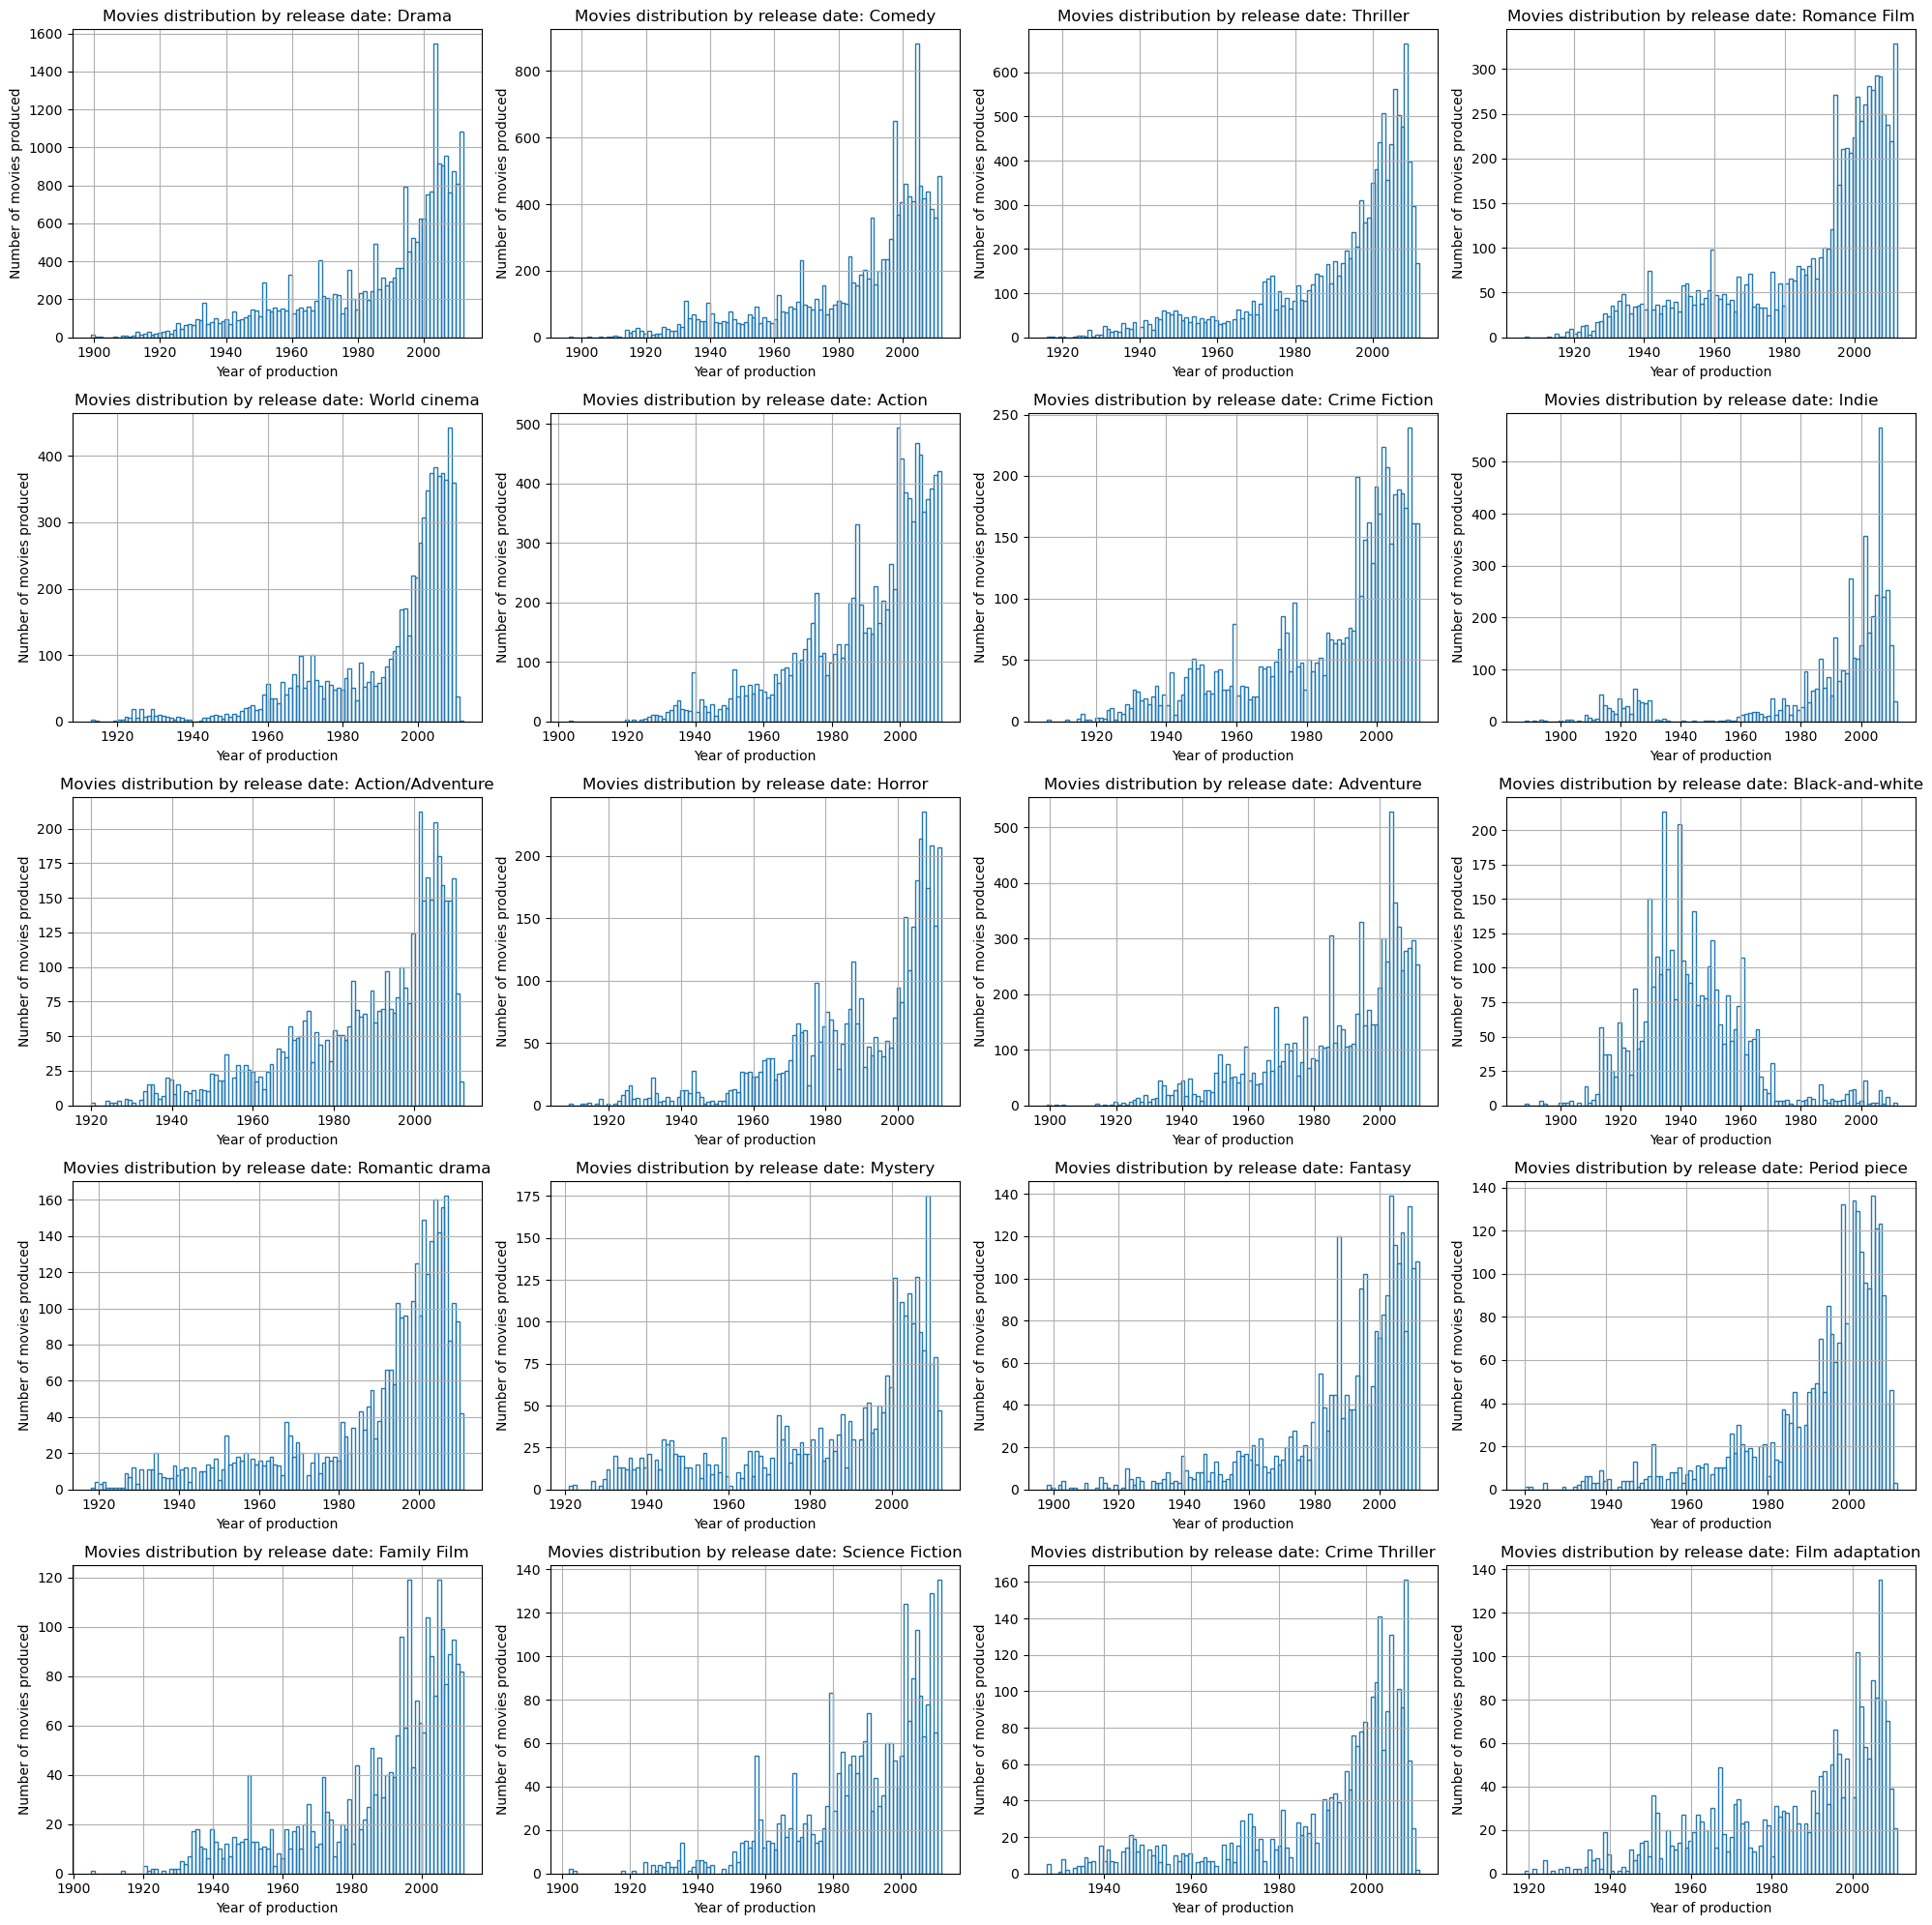

In [16]:
# Number of rows and columns for subplots
n_rows = 5
n_cols = 4

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Loop over the top 20 genres
for i, genre in enumerate(top_genres[:20]):
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {genre}')

    # Genre filtering
    genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    # Plot the histogram for the current genre
    ax.hist(genre_movies['release_date'], bins=100, **style)

    # Labels and limits
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    
    ax.grid(True)

plt.tight_layout()
plt.show()

Apart from the general increasing trend, probably also caused by the general increase in movies production over the last decades, some particular trends can be highlighted. For example, the indie genre seems to disappear between the 1940 and 1960. Adventure movies and drama movies present many peaks, that seem evenly paced at first glance. These observations can lead to further analysis.

Many meaningful themes for the analysis, for example the 'Space exploration' theme, are not classified as genres. Thus, the plots are used to identify common words and create new 'genres', definitely plot related.

In [17]:
# Counting space clusters entries occurances in 'plot_summary'
df_plots['space'] = df_plots['plot_summary'].apply(lambda x: cluster_search.col_search(x, cluster_space))

n_space = 3
df_plots_space = df_plots[df_plots['space'] > n_space]
df_plots = df_plots.drop(columns=['space'])

print('Number of movies that present the Space theme: ', len(df_plots_space))

Number of movies that present the Space theme:  198


The same reasoning can be applied to the communism theme, meaningful for more historical related analysis. The cluster search tool will probably be used for other theme clusters, meaningful for the overall analysis.

In [18]:
# Counting communism clusters entries occurances in 'plot_summary'
df_plots['communism'] = df_plots['plot_summary'].apply(lambda x: cluster_search.col_search(x, cluster_communism))

n_communism = 2
df_plots_communism = df_plots[df_plots['communism'] > n_communism]
df_plots = df_plots.drop(columns=['communism'])

print('Number of movies that present the Communism theme: ', len(df_plots_communism))

Number of movies that present the Communism theme:  95


# Regional (Countries and Continents) Analysis

First, some basic analysis must be conducted. For example, knowing how many different countries are there in the dataframe column 'countries' and which are the most common ones.

In [19]:
# Print the number of different countries
print('The number of different countries present in the dataframe is: ', len(df_movies_tmdb_ratings['countries'].unique()))

# Printing the number of movies per genre
print('\n Number of movies per country:')
print(df_movies_tmdb_ratings_genres_filtered['countries'].value_counts())

# Print the 20 most popular countries
print('\n Number of movies per popular country:')
print(df_movies_tmdb_ratings_genres_filtered['countries'].value_counts().head(20))

The number of different countries present in the dataframe is:  132

 Number of movies per country:
countries
United States of America            48651
United Kingdom                      11595
France                               6657
Germany                              4558
Italy                                3452
                                    ...  
Bangladesh                              2
Jordan                                  2
Montenegro                              2
Qatar                                   1
Democratic Republic of the Congo        1
Name: count, Length: 132, dtype: int64

 Number of movies per popular country:
countries
United States of America    48651
United Kingdom              11595
France                       6657
Germany                      4558
Italy                        3452
Canada                       3429
Japan                        2941
India                        2421
Australia                    2042
Hong Kong                    1835

To keep the analysis clear and readable, only a subset of countries must be considered. The code below checks if a subset of the 20 most common countries is representative of the totality of the movies produced.

In [20]:
# Define the most common countries
# Choosing the number of common countries
n = 20

# Selecting the n most common countries
countries_counts = df_movies_tmdb_ratings.groupby("countries").size()
countries_counts = countries_counts.sort_values(ascending=False)
countries_top = countries_counts.head(n)

top_countries_count = countries_top.sum()
all_countries_count = countries_counts.sum()

print(f"The 20 most common countries in the movies dataset account for {round(top_countries_count/all_countries_count * 100)}% of all movies produced.")

The 20 most common countries in the movies dataset account for 91% of all movies produced.


It can be concluded that the 20 most common countries account for the majority of the movies produced worldwide. Therefore, it may also suggest that some countries are culturally more prone to invest in the movies industry then other. Like it has been done for the genres, the distribution of movies produced in the 20 most common countries is plot. 

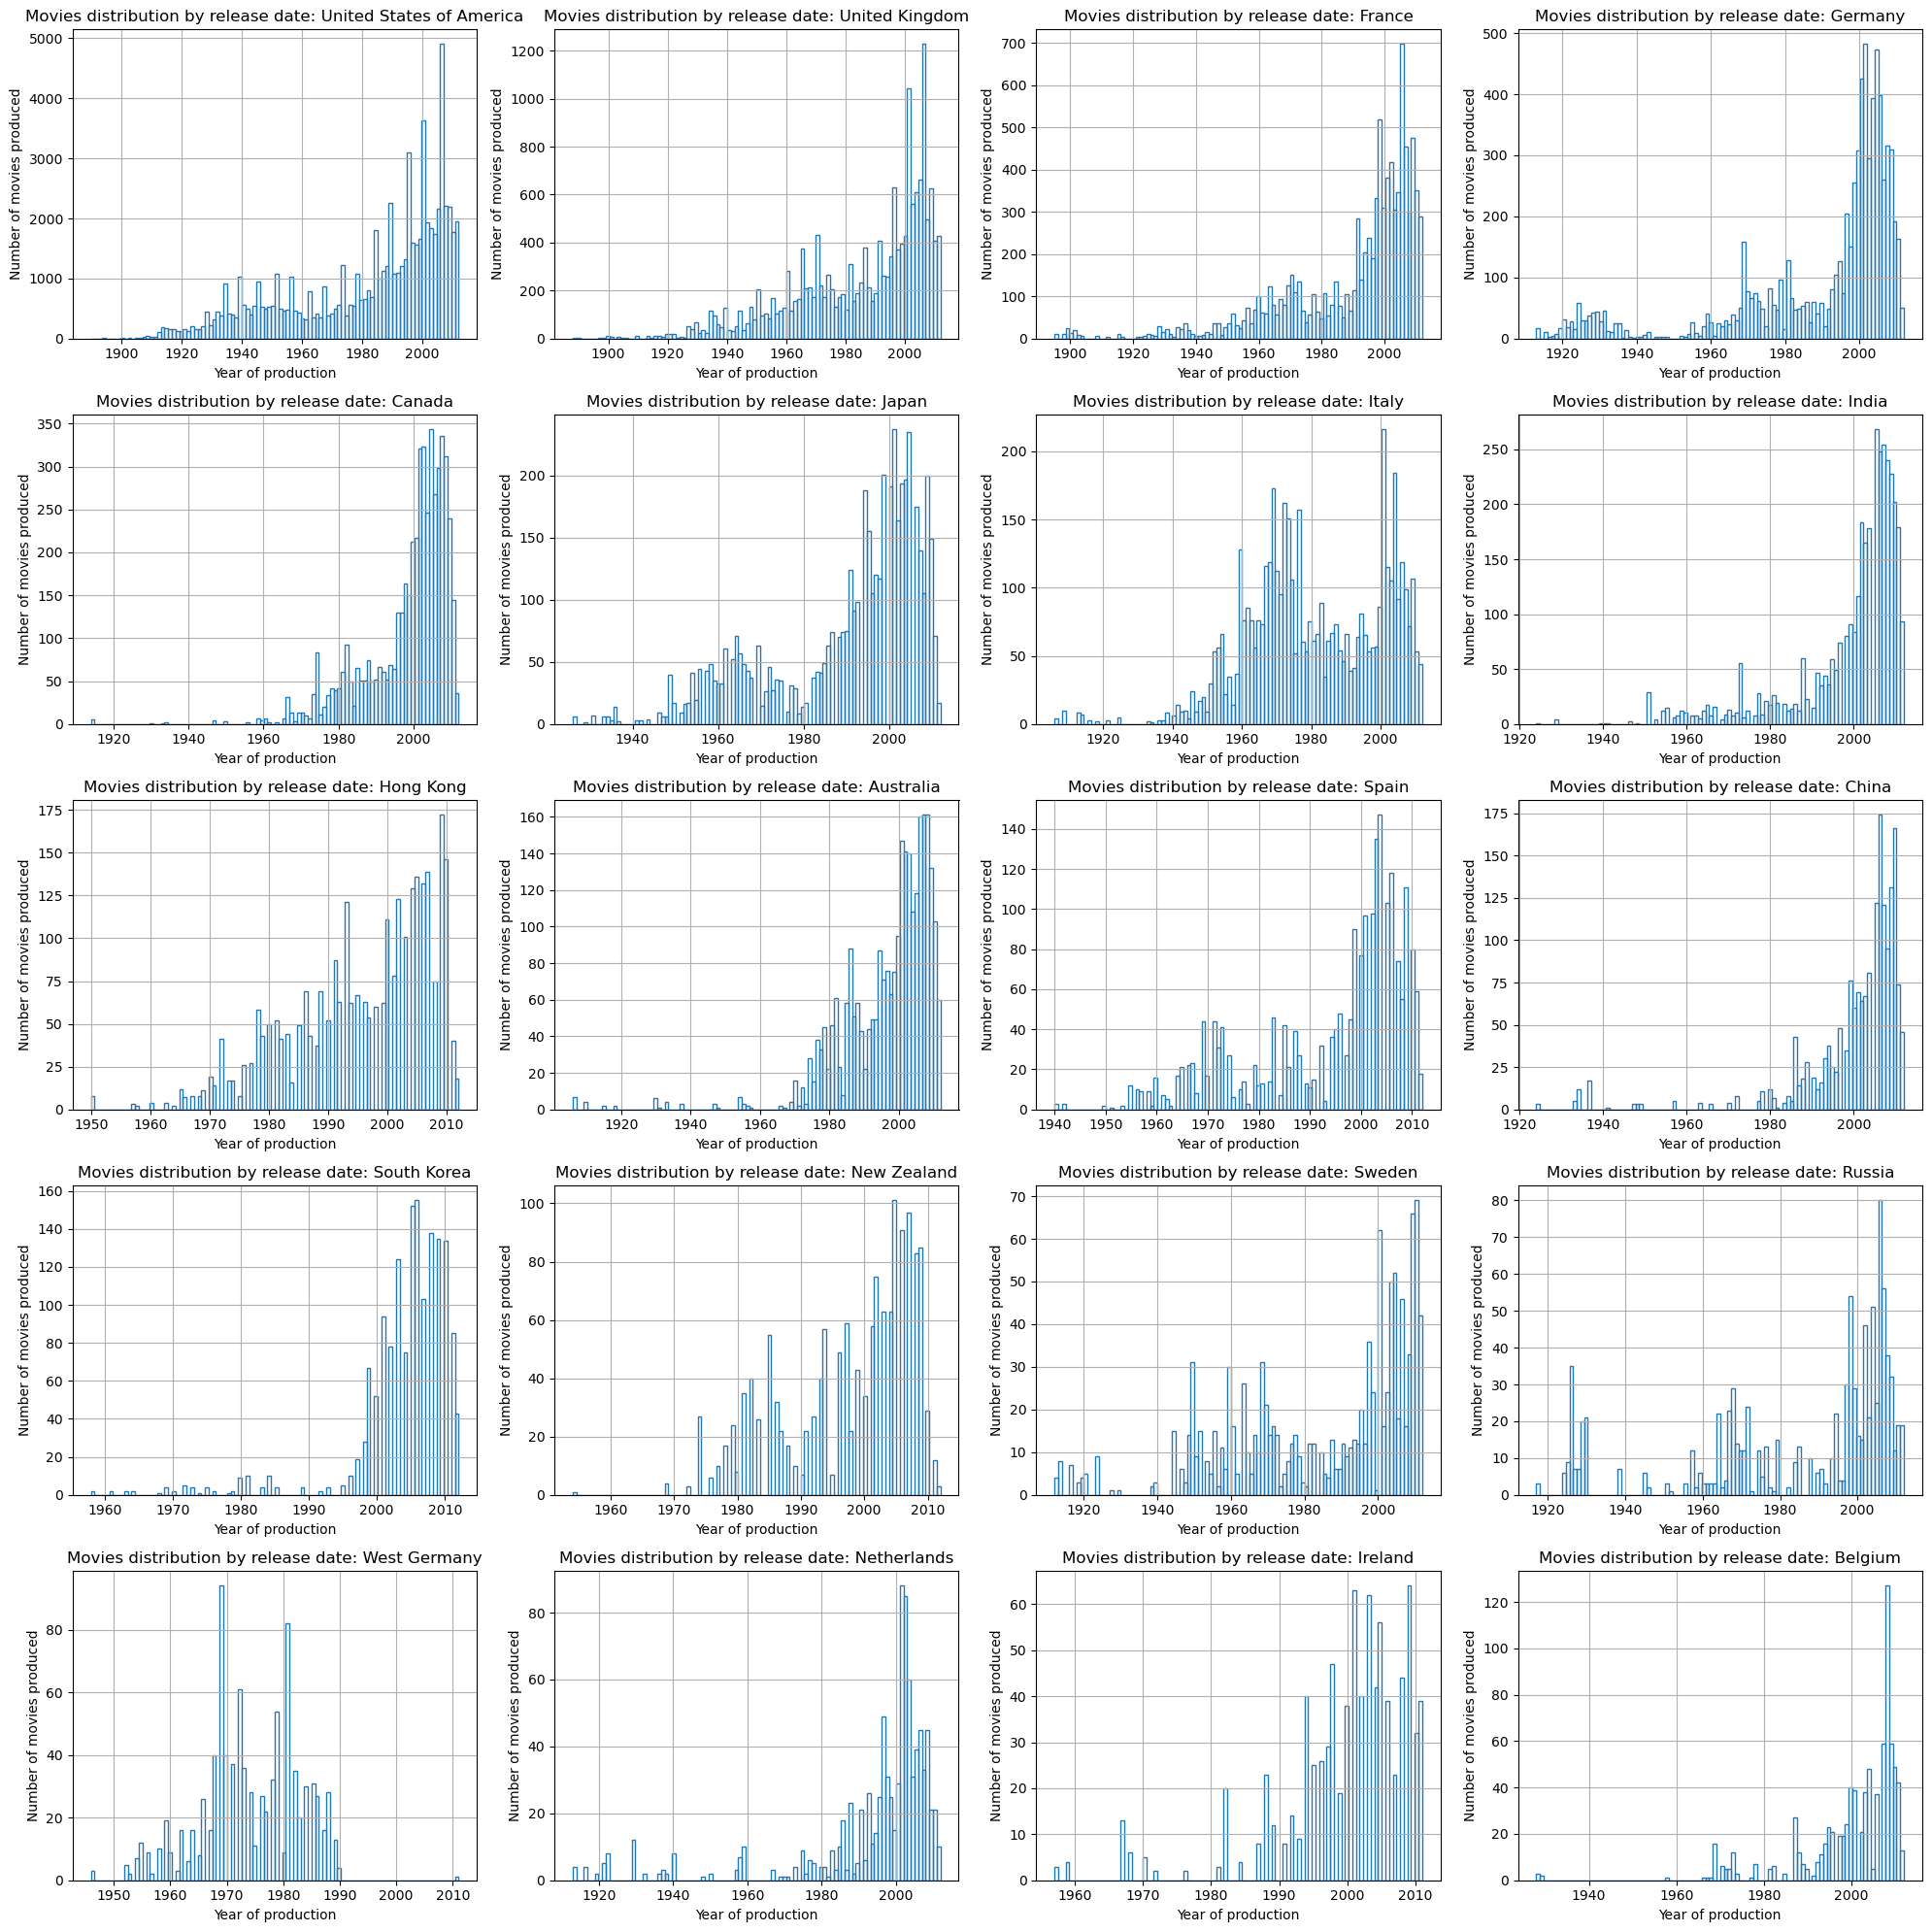

In [21]:
# Number of rows and columns for subplots
n_rows = 5
n_cols = 4

top_countries = countries_top.index.tolist()

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Loop over the top 20 genres
for i, country in enumerate(top_countries):
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {country}')

    # Genre filtering
    country_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['countries'].apply(lambda x: x is not None and country in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    # Plot the histogram for the current country
    ax.hist(country_movies['release_date'], bins=100, **style)

    # Labels and limits
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')
    
    ax.grid(True)

plt.tight_layout()
plt.show()

From the above graphs, many conclusion can be drawn. The countries here considered are mostly European, even though the United States clearly dominate over the others. Almost the totality of countries see an increase, in time, in the number of movies produced. An exception is West Germany, since the division of Germany into an Eastern and Western part ended in 1989. On the other heand, many countries, like the Netherlands, Belgium or South Korea, developed their movie industry only in the last decades, from 1980.

## Continent Division

To compact the analysis, regional groupings are needed. Before choosing randomic groups of countries, the focus shifts to continents, to analyse movies distribution between different areas of the globe.

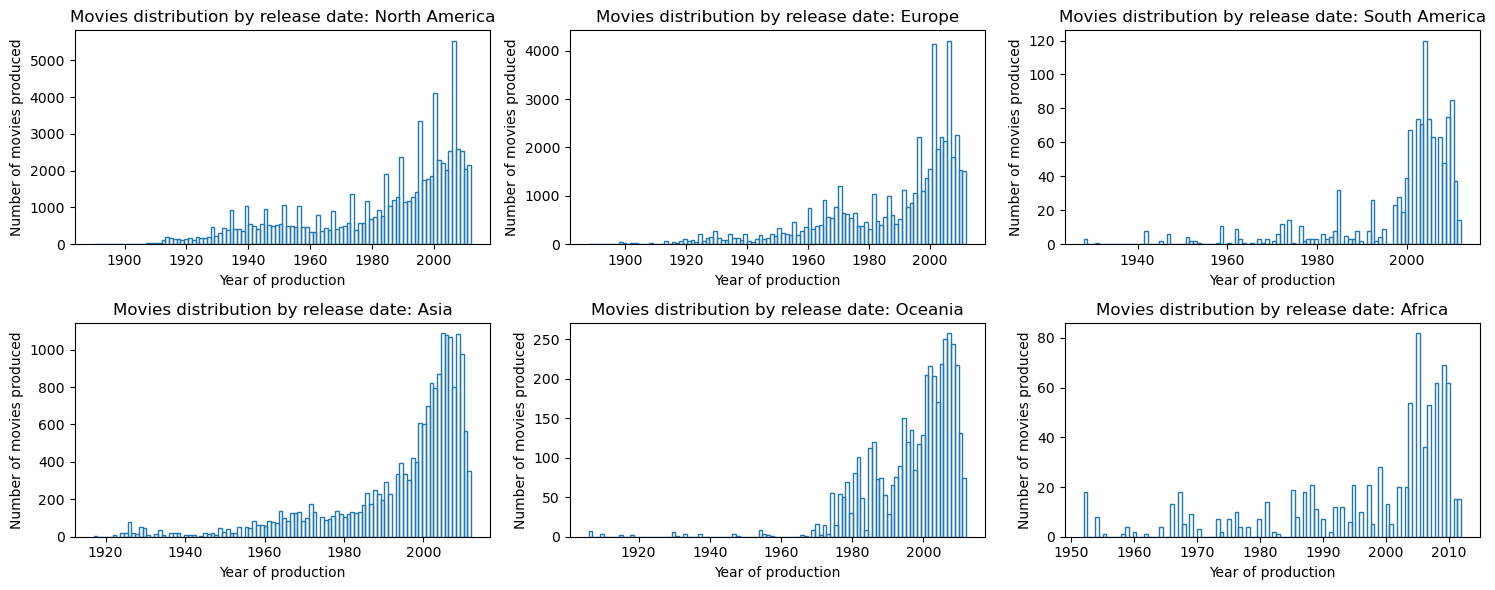

In [22]:
# Plot the movies distribution between different countries
# Number of rows and columns for subplots
n_cols = 3
n_rows = 2

top_countries = countries_top.index.tolist()

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,6))
axes = axes.flatten()
for i, continent in enumerate(['North America', 'Europe', 'South America', 'Asia', 'Oceania', 'Africa']):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {continent}')
    
    # continent filtering
    continent_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].apply(lambda x: isinstance(x, str) and x == continent)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(continent_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')


plt.tight_layout() 
plt.show()

From the plots above, some feature must be highlighted. For example, in North America movies production there are many peaks that look evenly paced. While Africa and South America present a net growth from the year 2000.

To plot the evolution of the number of movies produced in each continent, the graph below is reported.

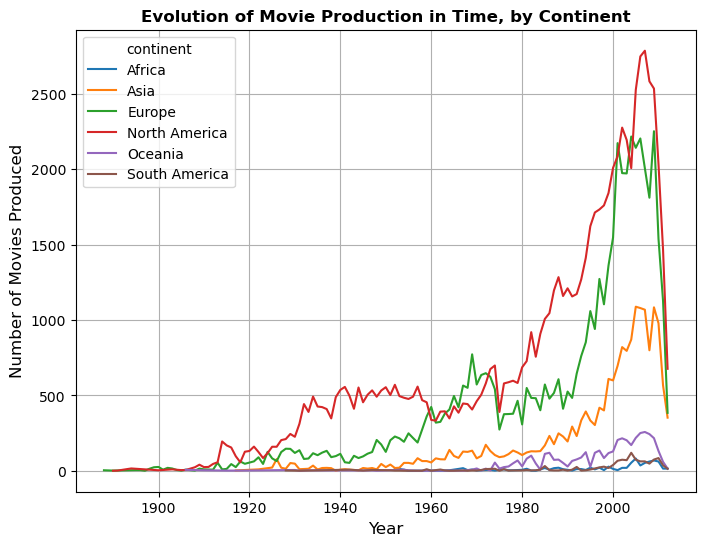

In [23]:
# Plot the evolution of movies produced by each continent
plt.figure(figsize=(8, 6))

# Group by continent and year to count the number of movies produced
sns.lineplot(x="release_date", y="movie_count", hue="continent", data=df_movies_tmdb_ratings.groupby(['continent', 'release_date']).size().reset_index(name='movie_count'))
plt.title("Evolution of Movie Production in Time, by Continent", weight = 'bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies Produced", fontsize=12)
plt.grid(True)
plt.show()

But what is the composition inside each continent? To answer this questions, some pie graphs are plotted, to undersand the weight of a specific country on the total number of movies produced in a continent. 

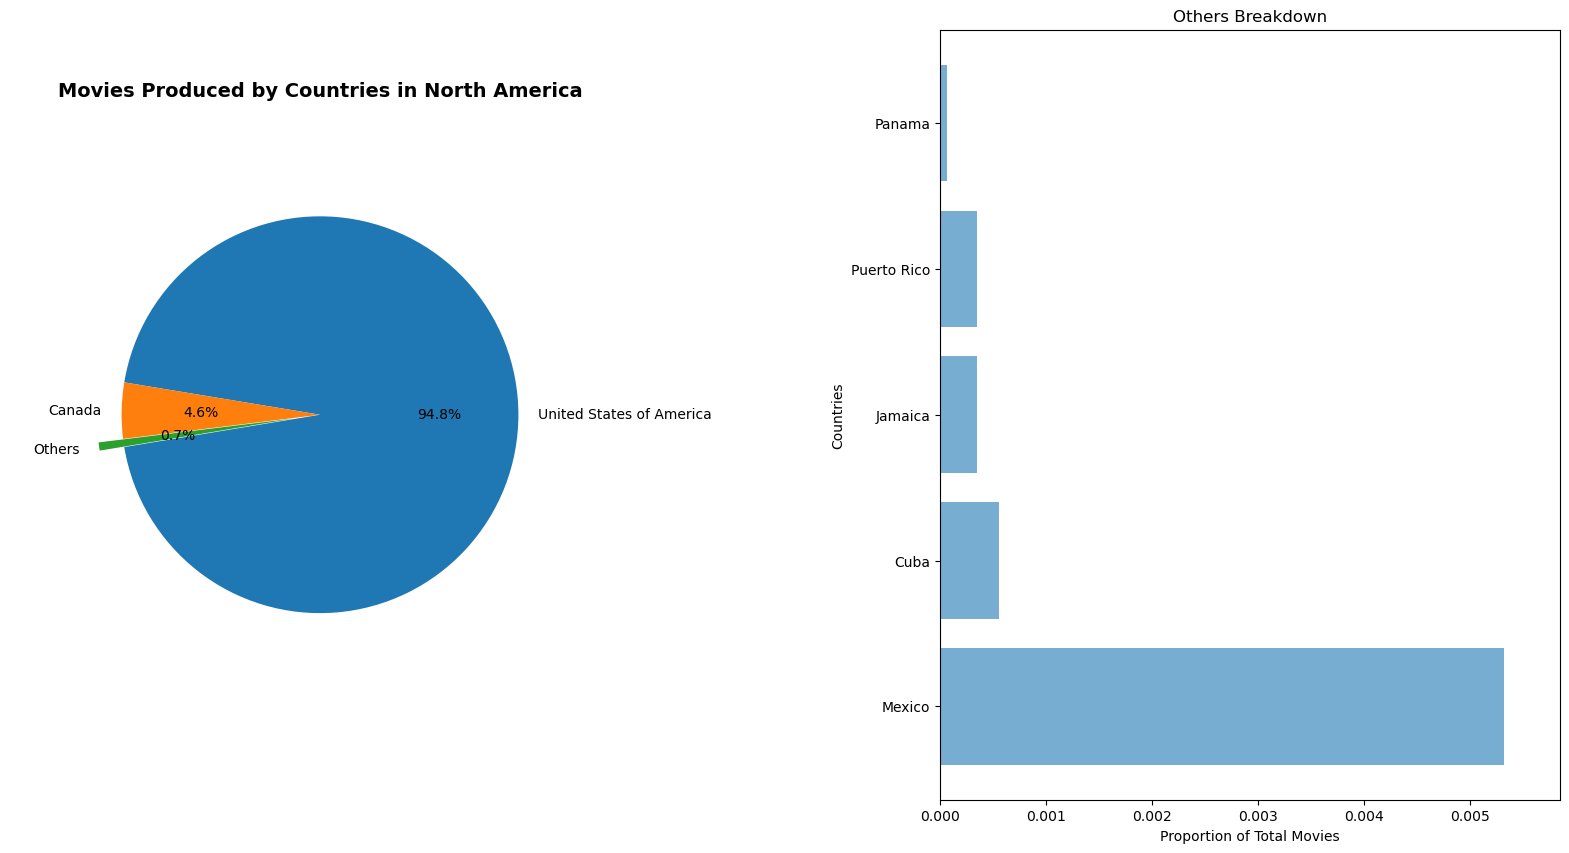

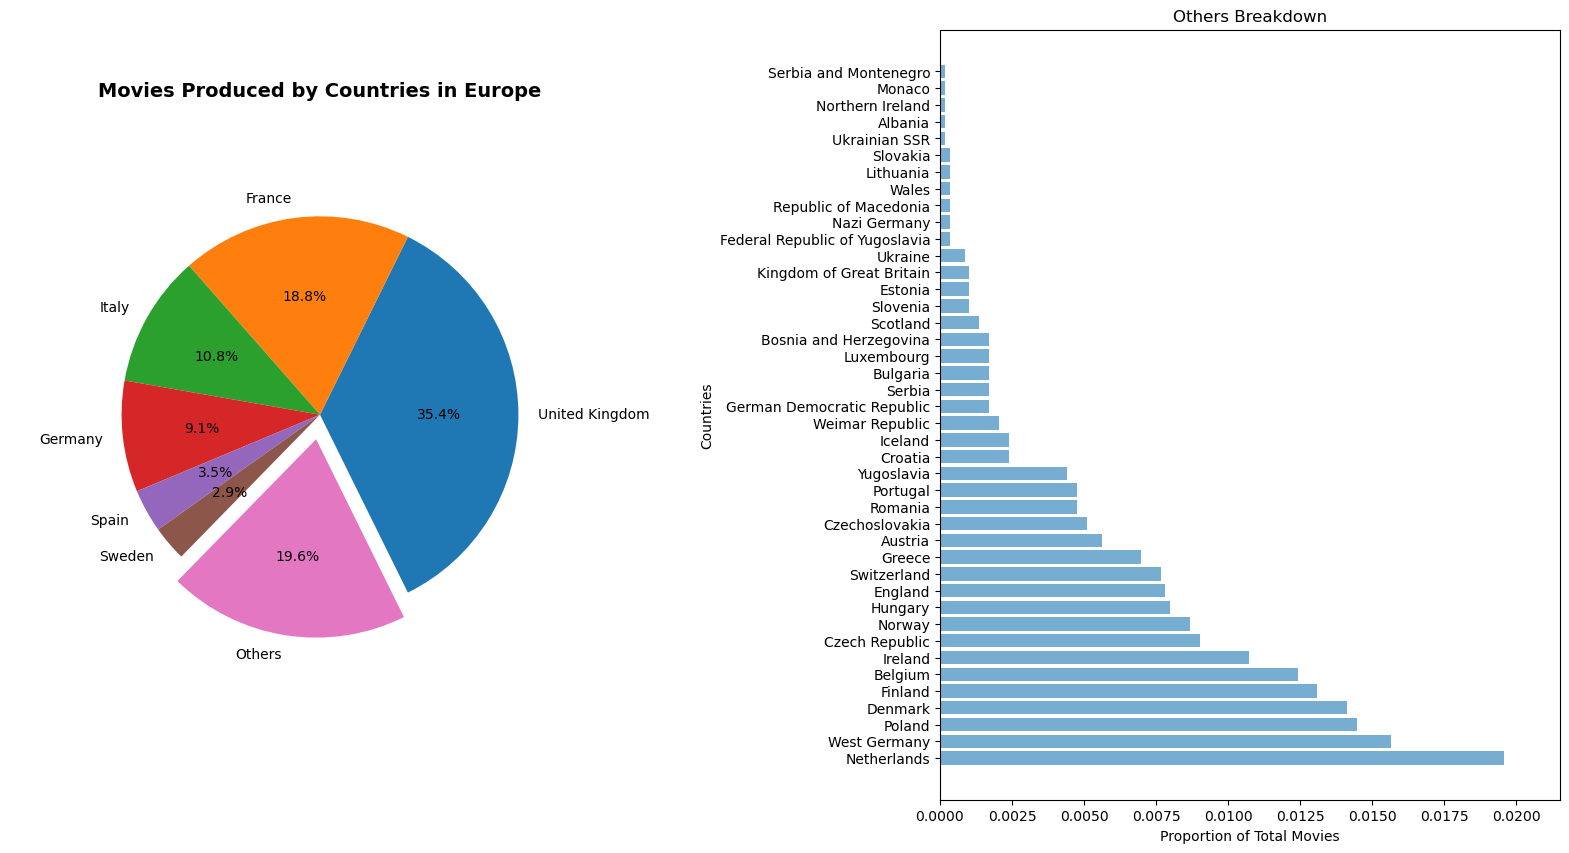

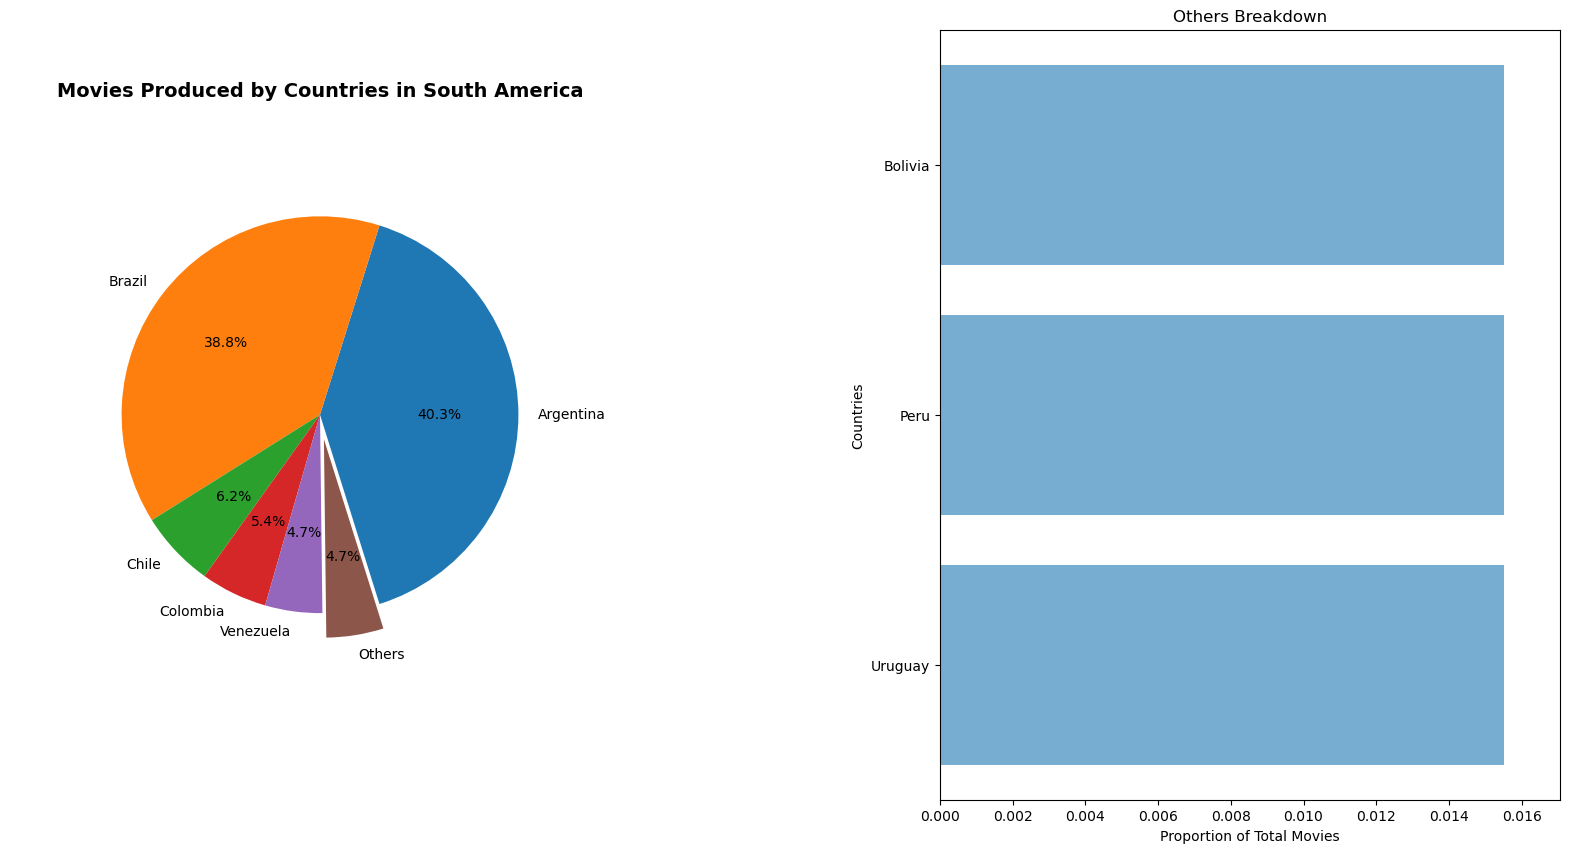

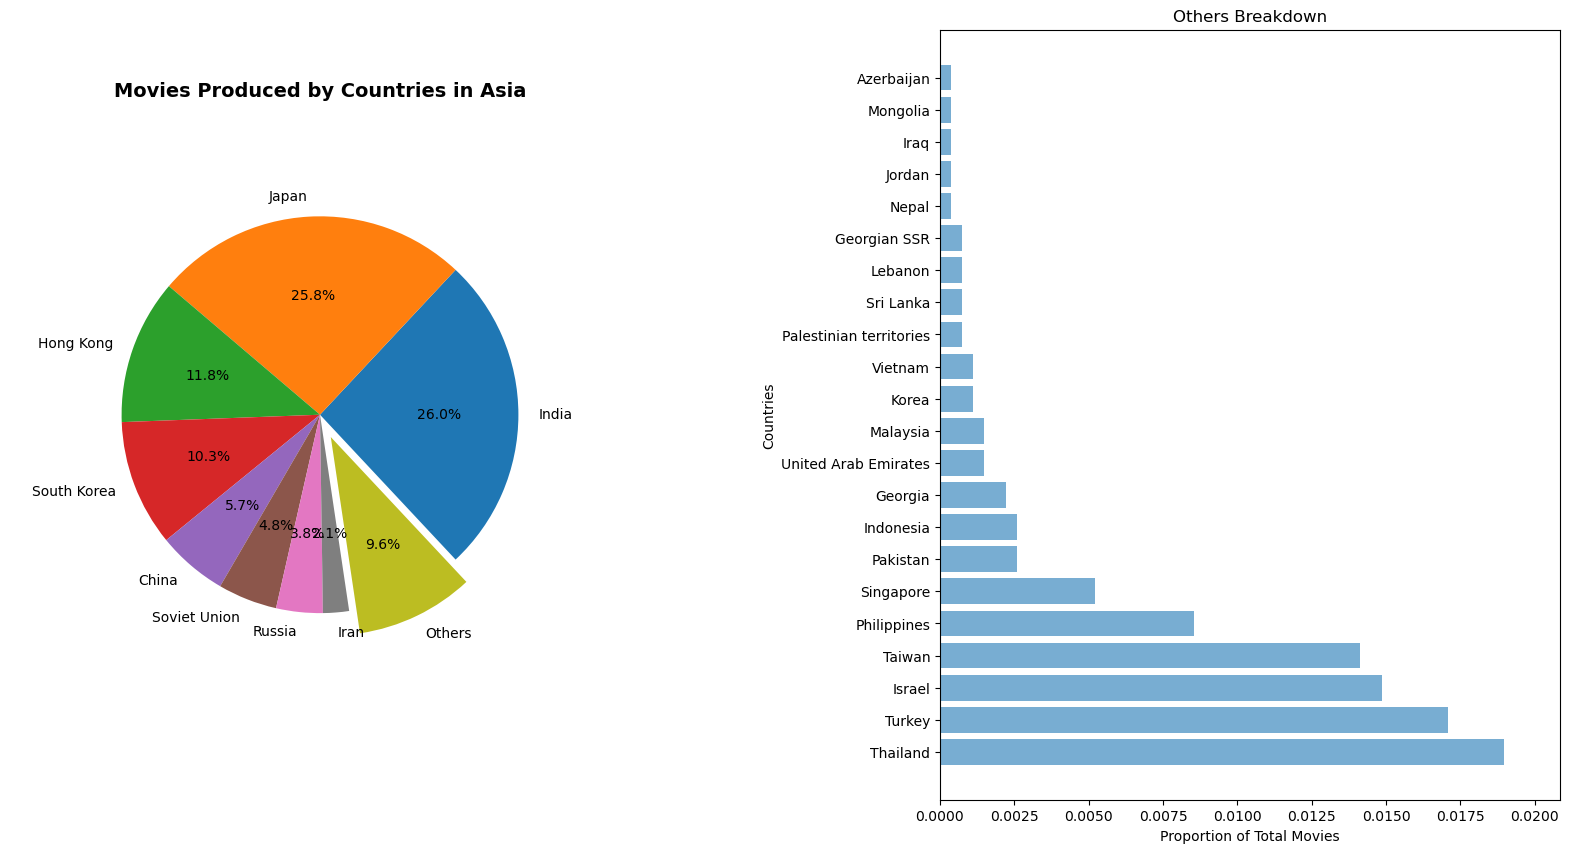

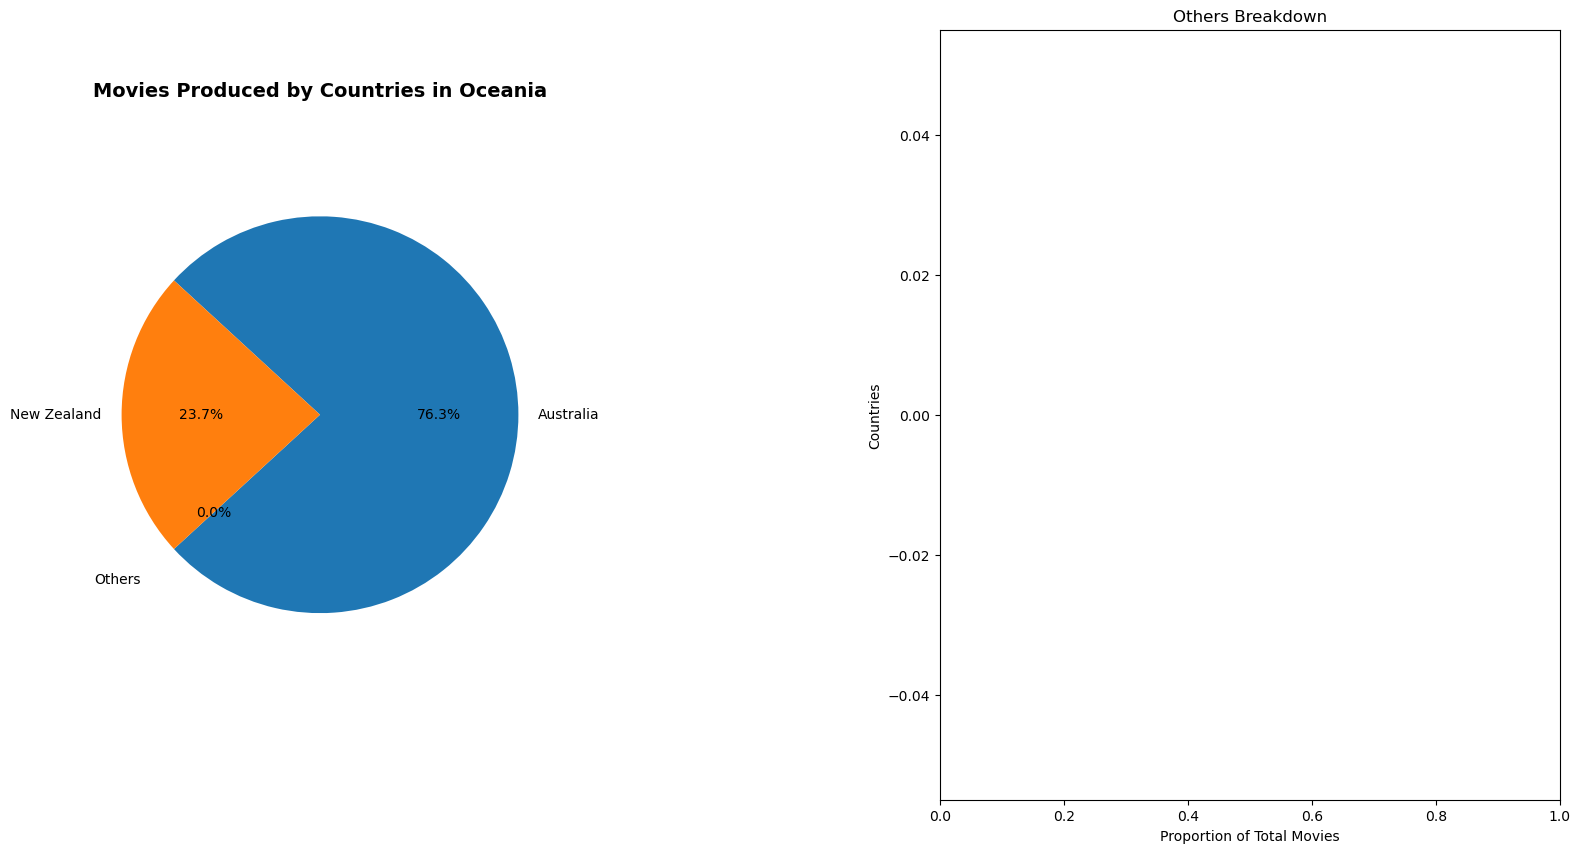

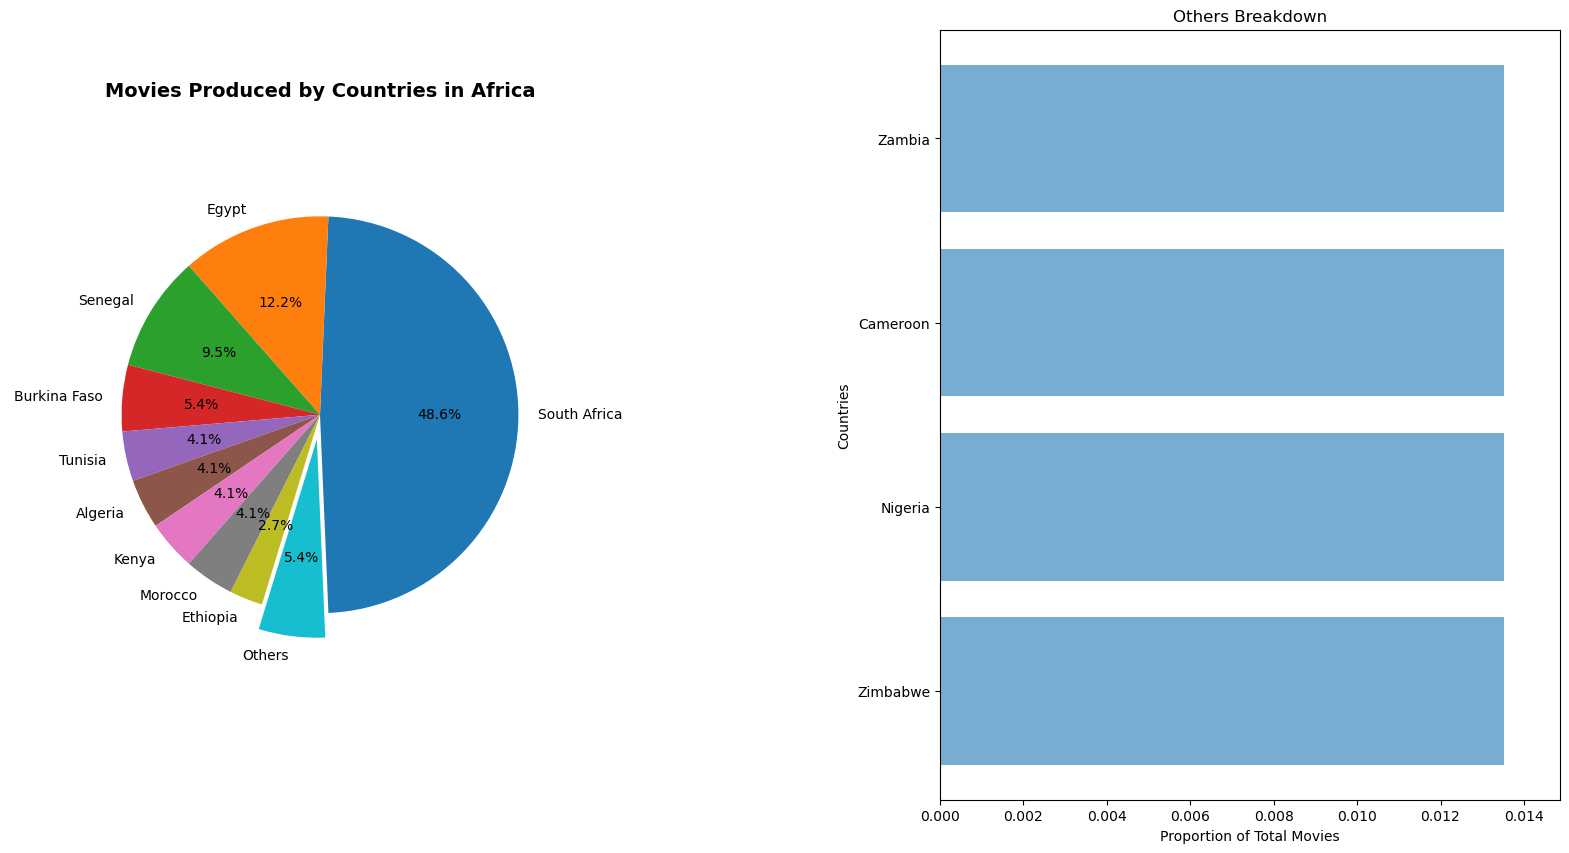

In [49]:
continents = ['North America', 'Europe', 'South America', 'Asia', 'Oceania', 'Africa']
threshold = 2

for continent in continents:
    # Filtering and counting
    continent_movies = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]
    movie_counts = continent_movies['countries'].value_counts()
    total_movies = movie_counts.sum()

    # Divide into small and large slices
    small_slices = movie_counts[(movie_counts / total_movies) * 100 < threshold]
    large_slices = movie_counts[(movie_counts / total_movies) * 100 >= threshold]

    # Create the 'Others' category
    others_count = small_slices.sum()
    movie_counts_combined = pd.concat([large_slices, pd.Series(others_count, index=["Others"])])

    # Calculate overall ratios
    overall_ratios = movie_counts_combined / total_movies
    labels = movie_counts_combined.index  
    explode = [0.1 if label == "Others" else 0 for label in labels]  # Esplodere la slice "Others"

    # 'Others' breakdown 
    others_breakdown = small_slices / total_movies 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.subplots_adjust(wspace=0.5)

    # Pie chart
    angle = -180 * overall_ratios.iloc[0] if len(overall_ratios) > 0 else 0
    wedges, texts, autotexts = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                                    labels=labels, explode=explode, radius=0.8)
    ax1.set_title(f'Movies Produced by Countries in {continent}', weight = 'bold', fontsize = 14)

    # Bar chart to explain the ìOther section
    ax2.barh(others_breakdown.index, others_breakdown, color='C0', alpha=0.6)
    ax2.set_title('Others Breakdown')
    ax2.set_xlim(0, max(others_breakdown) * 1.1 if len(others_breakdown) > 0 else 1)
    ax2.set_ylabel('Countries')
    ax2.set_xlabel('Proportion of Total Movies')

    plt.show()

The pie graphs present all major differences. For example, the number of countries varies considerably (Europe), there are more balanced charts and completely unbalanced ones (North America). After this first analysis on continents, regions of interest can be identified to better model the data story. In every case, the continent analysis has been essential to understand hotspots in the worldwide movies distribution.

## Brief Example of Genres/Continent Combined Analysis 

In the following code and graphs, a brief initial example of analysis combining genres and the regional aspect is presented. The genre 'War film' has been easy to identify and it is probably related to world historical events. First, plot the distribution over release date.

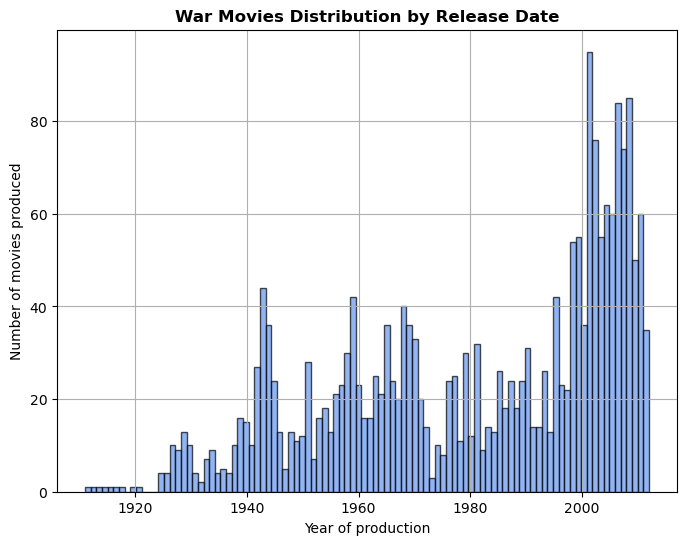

In [ ]:
# Plot the distribution of war films overtime
plt.figure(figsize=(8,6))
plt.title('War Movies Distribution by Release Date', weight = 'bold')

war_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'] == 'War film']
plt.hist(war_movies['release_date'], bins= 100, edgecolor='black', alpha=0.7, color='cornflowerblue')

plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True)
plt.show()

Now that the distribution is plotted, it can be seen the usual increase of movies after year 2000. A particular feature of this graph is that, during WWII the number of war films is larger than the number of war films produced immediately after te war. Another anomaly can be seen in the 70s, when almost no war films were produced worldwide. Now, it is interesting to plot which continents contributed more to the production of such genres.

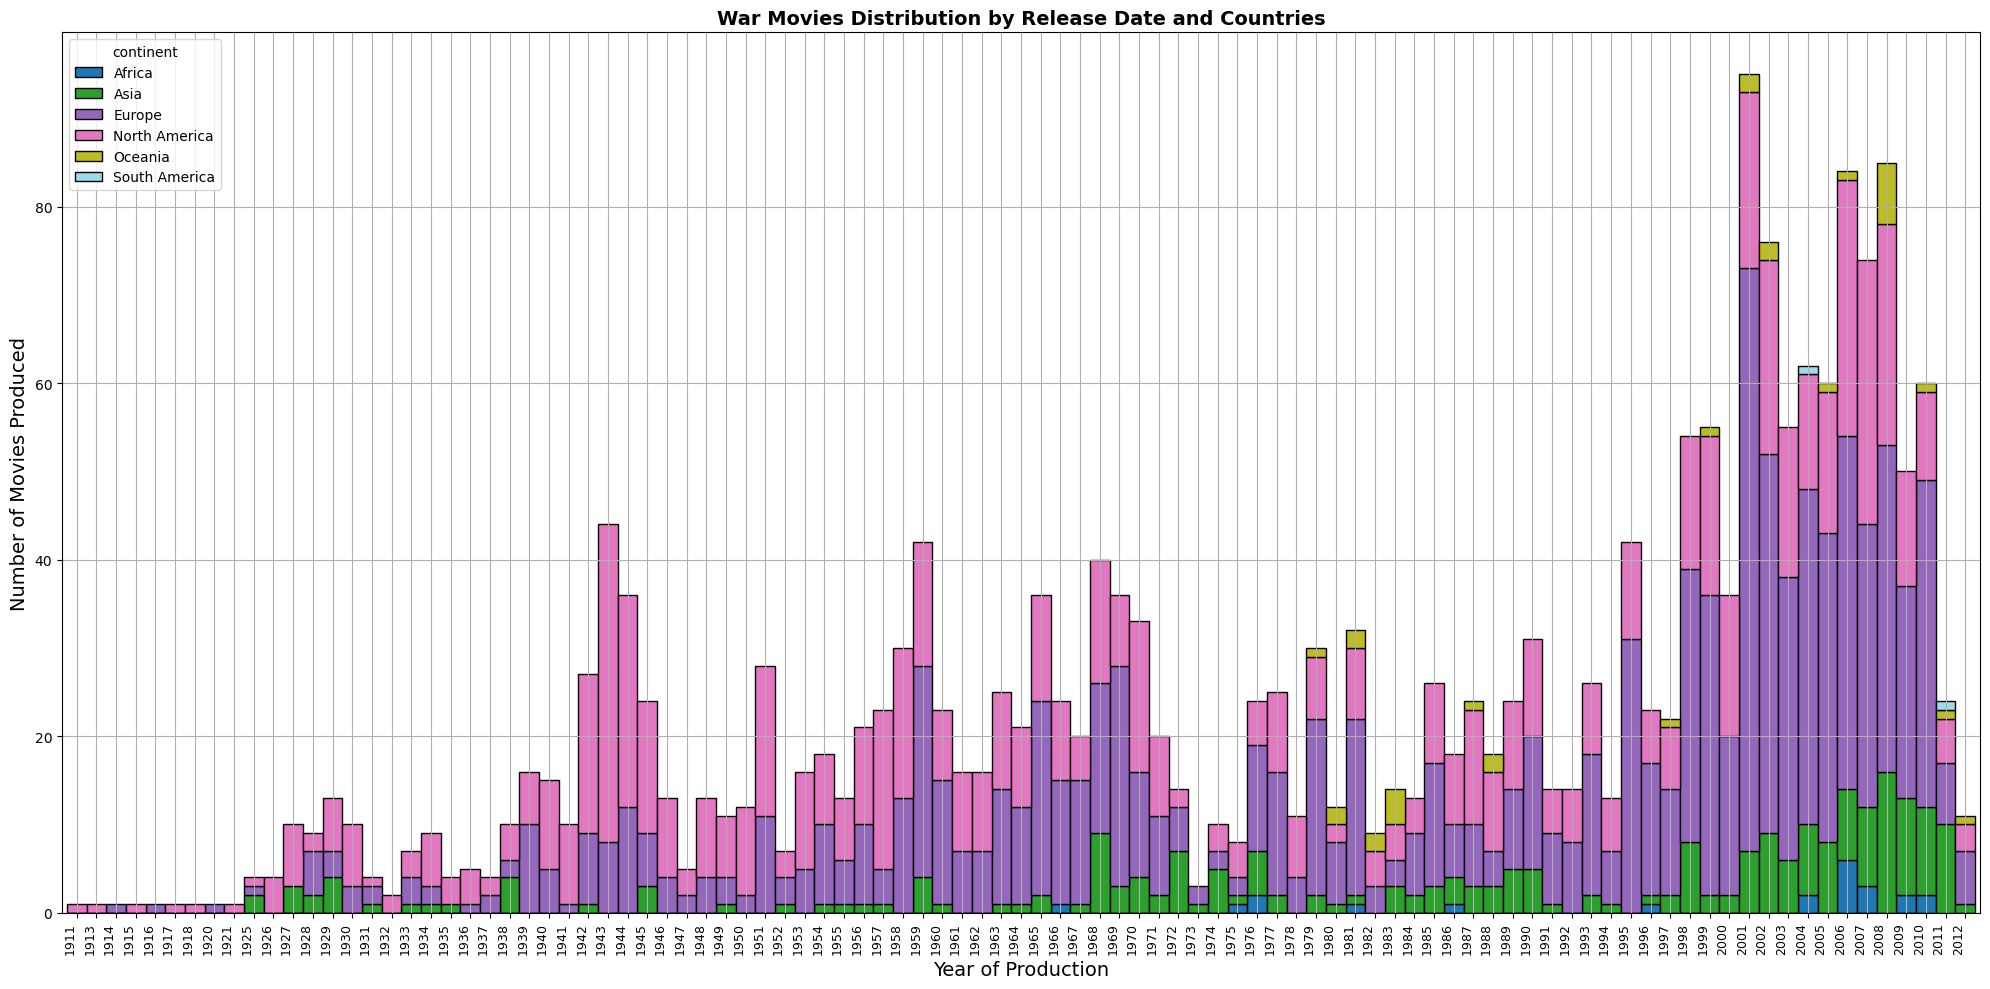

In [ ]:
# Grouping by continent, to visualize this attribute
grouped_war_movies = war_movies.groupby(['release_date', 'continent']).size().unstack(fill_value=0)

# Plot stacked bar chart for grouped war movies
ax = grouped_war_movies.plot(kind='bar', stacked=True, figsize = (20, 10), colormap='tab20', width=1, edgecolor='black')
plt.title('War Movies Distribution by Release Date and Countries', weight = 'bold', fontsize = 14)

# Adjust the x-ticks and labels
plt.xlabel('Year of Production', fontsize = 14)
plt.ylabel('Number of Movies Produced', fontsize = 14)
plt.xticks(rotation=90, ha="right", fontsize=9)  # Rotate x labels for better readability


plt.tight_layout()
plt.grid(True)
plt.show()

As expected, the majority of these movies are produced in Europe or North America, which are the major movies producers worldwide. Even though Asia is also a big contributor, the war film genre does not seem the focus of its production.

Analyzing the genre, it is known that the 'War film' genre can be combined with other multiple genres, which can give more information about the generall movie theme.

                   Genre  Frequency
3                  Drama       1972
10                Action        640
2           World cinema        567
29          Romance Film        488
14      Action/Adventure        460
..                   ...        ...
89  ['Historical drama']          1
90           ['History']          1
78      ['Romance Film']          1
93   ['Japanese Movies']          1
94            ['Comedy']          1

[95 rows x 2 columns]


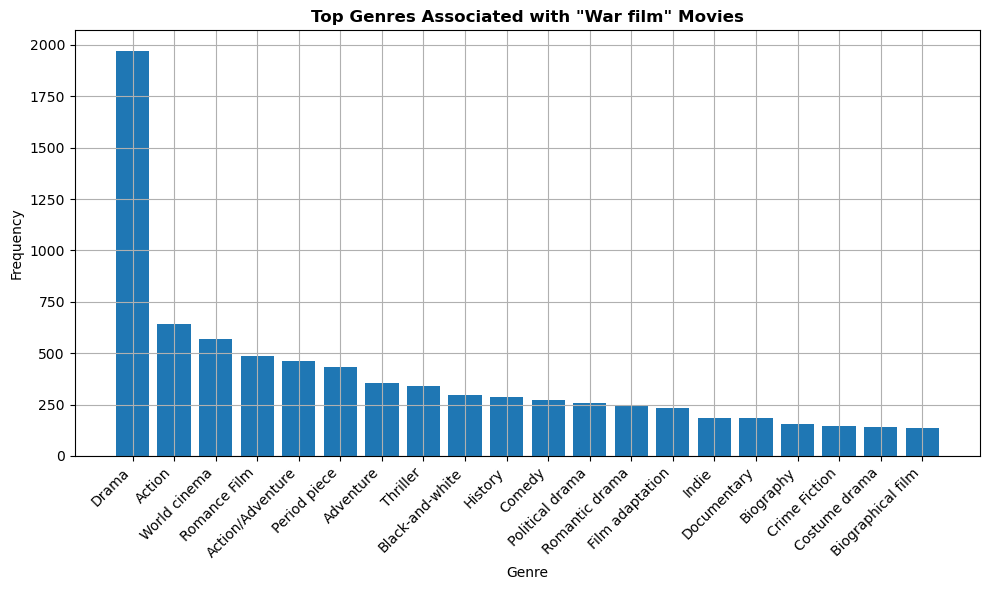

In [72]:
# Since the dataframe contains one genres per row, titles are used to pair the War film movie to its other genres
# Extract titles
war_titles = war_movies['title'].unique()

# Filter again, excluding the genre 'War film'
war_combined_genres = df_movies_tmdb_ratings[(df_movies_tmdb_ratings['title'].isin(war_titles)) & (df_movies_tmdb_ratings['genres'] != 'War film')]

# Use the counter to count the frequency of other genres
war_combined_genres_counts = Counter(war_combined_genres['genres'])
df_war_combined_genres = pd.DataFrame(war_combined_genres_counts.items(), columns=['Genre', 'Frequency'])

# Ordina per frequenza
df_war_combined_genres = df_war_combined_genres.sort_values(by='Frequency', ascending=False)

# Mostra il risultato
print(df_war_combined_genres)

# Show the most common 20 genres
plt.figure(figsize=(10, 6))
plt.bar(df_war_combined_genres['Genre'][:20], df_war_combined_genres['Frequency'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top Genres Associated with "War film" Movies', weight = 'bold')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.tight_layout()
plt.grid(True)
plt.show()

It would be interesting to combine this analysis with ratings, to understand where this genre is most appreciated and if the general sentiment toward such a violent theme changes over time. It would be also interesting to see if the 'War' theme, find with the cluster method, coicides exactly with the 'War film' genres or if there are more movies, not included in the group.

# Ratings Analysis

First, the plot below provides information on the mean movie ratings distribution. Ratings are given in a range from 0 to 5.

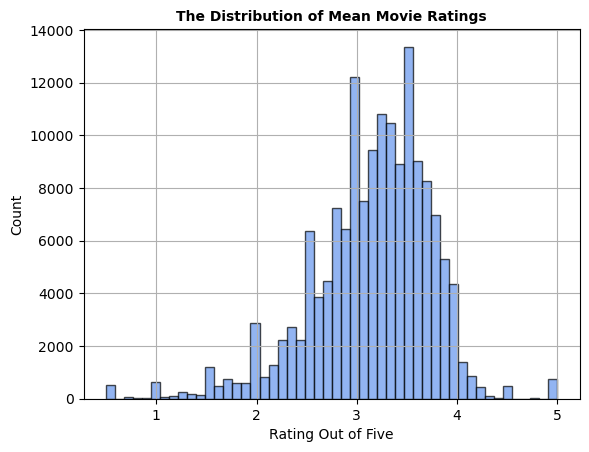

In [26]:
# Plot the distribution of counts of movie ratings
plt.hist(df_movies_tmdb_ratings['mean_rating'].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Five', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True)
plt.show()


Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since the distribution resemble a normal distribution, some test to verify this hypothesis are run below.

In [27]:
diagnostic.kstest_normal(df_movies_tmdb_ratings['mean_rating'].values, dist = 'norm') 

(0.08479507470939335, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, we are again convinced this isn't the case based on visual inspection of the ratings distribution. Therefore, a Q-Q plot is again employed to further assess normality.

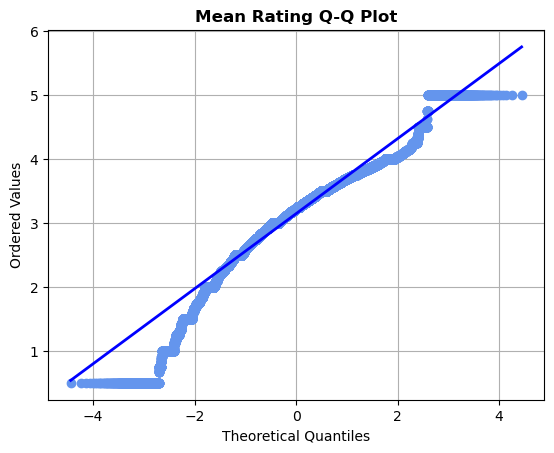

In [28]:
# Plot Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_tmdb_ratings['mean_rating'].values, dist="norm", plot=ax)

# Line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

plt.show()

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

To better understand the 'mean rating' attribute, its description is needed.

In [29]:
df_movies_tmdb_ratings["mean_rating"].describe()

count    156838.000000
mean          3.146822
std           0.600265
min           0.500000
25%           2.833333
50%           3.228208
75%           3.545918
max           5.000000
Name: mean_rating, dtype: float64

The movie ratings found for part of the CMU dataset have a mean -- which it is reported owing to the above conclusion of the mean ratings being approximately normal -- of 3.15. The standard deviation is 0.6 and no ratings under 0.5 are observed, whereas perfect ratings are observed.

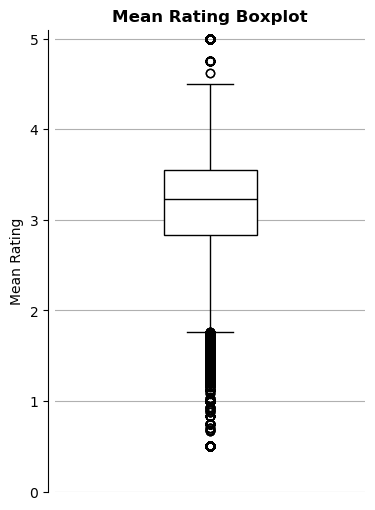

In [30]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_tmdb_ratings['mean_rating'], color='white', linecolor='black', width=0.3)

sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,5.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

fig.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a five point scale and no extreme values greatly drive skew in the movies ratings.

Now, a closer look to genres preferences is presented. The objective is to visualize if the mean movie rating changes, based on the movie genre.

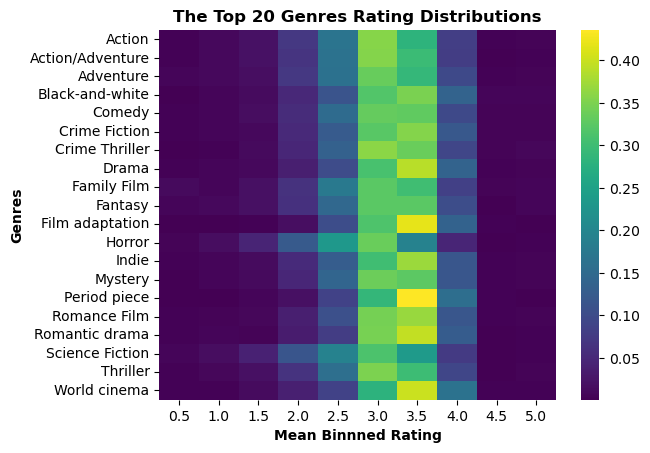

In [31]:
df_genres_meanratings = pd.crosstab(df_movies_tmdb_ratings_genres_filtered['genres'],df_movies_tmdb_ratings_genres_filtered['mean_rating_binned'], normalize='index')

ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='viridis', ax = ax)

ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')
plt.show()

The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 3.0 and 3.5 rating bins, as expected given the population's mean rating of 3.15. Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since no evident movie genre preference has been found, other parameters are compared to the mean rating, to find correlations. For example, runtime and release date.

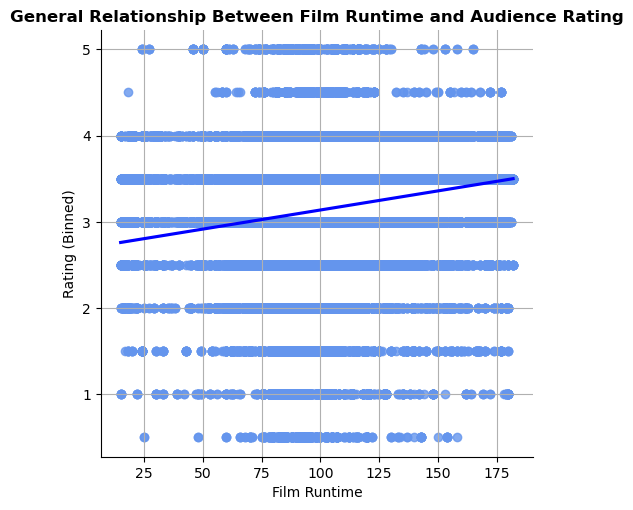

In [32]:
# Starting by plotting the relationship between runtime and mean rating
runtime_binned_ratings = df_movies_tmdb_ratings[['runtime','mean_rating_binned']]
sns.lmplot(x='runtime',y='mean_rating_binned', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Film Runtime")
plt.ylabel("Rating (Binned)")
plt.title("General Relationship Between Film Runtime and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

From the above graph, it can be concluded that there may be a relationship between runtime of a movie and the audience rating. Indeed, the linear regression segment has a positive coefficient. The above analysis performed over all regions and then across time worldwide and per region would give meaningful insights to understand regional movies preferences

The same plot has been done to compare the rating and the release date.

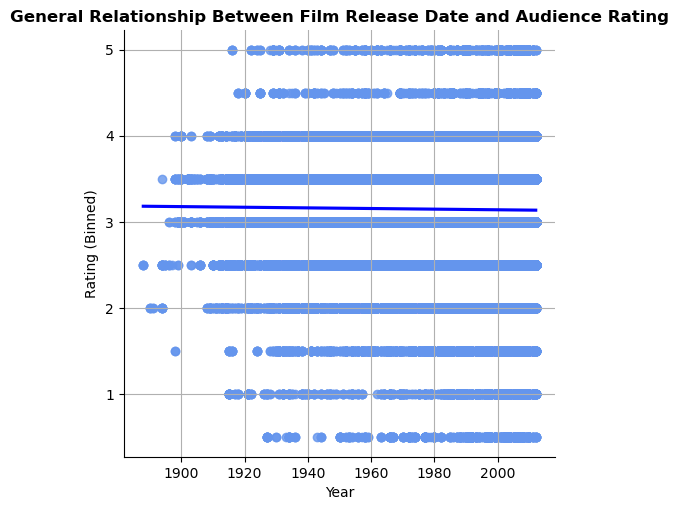

In [33]:
# Plot the relationship between release date and mean rating
runtime_binned_ratings = df_movies_tmdb_ratings[['release_date','mean_rating_binned']]
sns.lmplot(x='release_date',y='mean_rating_binned', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Year")
plt.ylabel("Rating (Binned)")
plt.title("General Relationship Between Film Release Date and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

From the above graph, it can be stated that there is no major difference in ratings over time. But a deeper analysis, per country or per region, could give some useful information.

## Matching for causality

A meaningful possible analysis is comparing a given genre rating across two regions for causality analysis of country on rating. This analysis would need to be repeated per region pairing of interest, per genre of interest, across unique time subsets of the dataset based on decades/ events of interest. In the example below, the focus is on thriller movies in the US vs in the UK.

First, the nature randomization matching method is used to study causality.

In [34]:
# identifying movies that have several entries but that differ in ratings
df_movies_ratings_unique = df_movies_tmdb_ratings.drop_duplicates(subset=["title", "mean_rating"]).copy()

# keeping only movies that have several ratings, replicating random experiment
recurrent_title = df_movies_ratings_unique["title"].value_counts() > 1
df_movies_ratings_unique = df_movies_ratings_unique[df_movies_ratings_unique["title"].isin(recurrent_title[recurrent_title].index)]

In [35]:
# thriller, US versus UK, all time
thriller_us = df_movies_ratings_unique[(df_movies_ratings_unique["genres"] == "Thriller") & (df_movies_ratings_unique["countries"] == "United States of America")]
thriller_uk = df_movies_ratings_unique[(df_movies_ratings_unique["genres"] == "Thriller") & (df_movies_ratings_unique["countries"] == "United Kingdom")]

print('The total number of thriller movies produced in the US is: ', len(thriller_us))
print('The total number of thriller movies produced in the UK is: ', len(thriller_uk))

The total number of thriller movies produced in the US is:  185
The total number of thriller movies produced in the UK is:  38


There are very few movies that are thrillers that were produced in the US and in the UK, all else being the same. Relying on nature randomization is not going to work for matching.

Therefore, another method is used: propensity scoring. It consists in generating propensity scores based on release date and runtime, the only two real features of interest with genre held constant.

In [36]:
# comparing the ratings of thriller films in the US versus the UK
thriller_us_uk = pd.concat([thriller_us, thriller_uk])

# make the USA as a thrillers production country as the treatment
thriller_us_uk["countries"] = thriller_us_uk["countries"].apply(lambda x: x.replace("United Kingdom", "0"))
thriller_us_uk["countries"] = thriller_us_uk["countries"].apply(lambda x: x.replace("United States of America", "1"))
thriller_us_uk = thriller_us_uk.astype({'countries':'int'})

In [37]:
# generating propensity scores based on release date and runtime, the only two real features of interest with genre held constant
thriller_us_uk['release_date'] = (thriller_us_uk['release_date'] - thriller_us_uk['release_date'].mean())/thriller_us_uk['release_date'].std()
#thriller_us_uk['revenue'] = (thriller_us_uk['revenue'] - thriller_us_uk['revenue'].mean())/thriller_us_uk['revenue'].std()
thriller_us_uk['runtime'] = (thriller_us_uk['runtime'] - thriller_us_uk['runtime'].mean())/thriller_us_uk['runtime'].std()

mod = smf.logit(formula='countries ~  release_date + runtime' , data=thriller_us_uk)
res = mod.fit()
print(res.summary())

thriller_us_uk["Propensity_score"] = res.predict()

Optimization terminated successfully.
         Current function value: 0.443244
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              countries   No. Observations:                  223
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            2
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                 0.02909
Time:                        17:45:38   Log-Likelihood:                -98.843
converged:                       True   LL-Null:                       -101.81
Covariance Type:            nonrobust   LLR p-value:                   0.05173
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6444      0.188      8.769      0.000       1.277       2.012
release_date     0.2024

Low R^2 value, which is concerning. An increase in release date by one standard deviation leads to a 0.13 log odds increase in a thriller being released in the US. An increase of one standard deviation in the runtime of a movie leads to a 0.11 log odds reduction in a movie being released in the US.

In [38]:
# matching US and UK thrillers based on propensity scores
def get_similarity(propensity_score1, propensity_score2):
    return 1-np.abs(propensity_score1-propensity_score2)

not_treated = thriller_us_uk[thriller_us_uk['countries'] == 0]
treated = thriller_us_uk[thriller_us_uk['countries'] == 1]

G = nx.Graph()

for control_id, control_row in not_treated.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

balanced_thriller_us_uk = thriller_us_uk.loc[matched]

With the two boxplots below runtime and release date are compared, and they must be equal for the two countries.

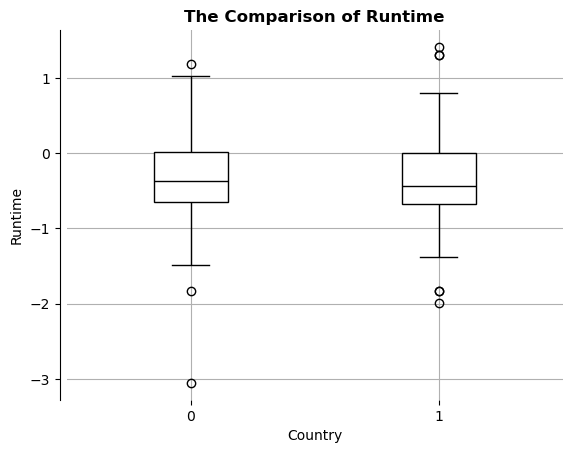

In [39]:
# assessing runtime balance in matched dataset
ax = sns.boxplot(x="countries", y="runtime", data=balanced_thriller_us_uk, color='white', linecolor='black', width=0.3)
sns.despine(offset=5, trim=False, bottom=True)

plt.xlabel("Country")
plt.ylabel("Runtime")
plt.title("The Comparison of Runtime", weight='bold')
plt.grid(True)
plt.show()


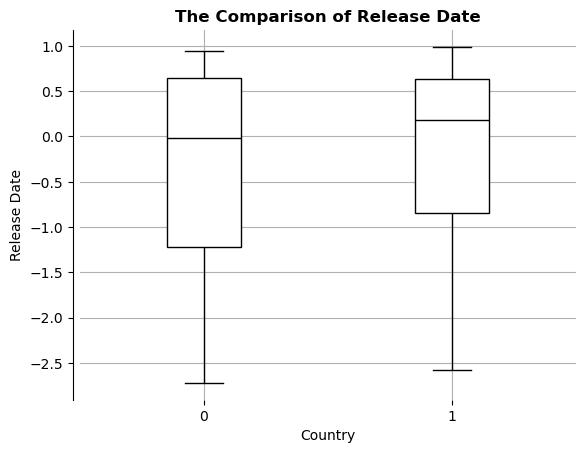

In [40]:
# assessing release date balance in matched dataset
ax = sns.boxplot(x="countries", y="release_date", data=balanced_thriller_us_uk, color='white', linecolor='black', width=0.3)
sns.despine(offset=5, trim=False, bottom=True)

plt.xlabel("Country")
plt.ylabel("Release Date")
plt.title("The Comparison of Release Date", weight='bold')
plt.grid(True)
plt.show()

count    38.000000
mean      2.948698
std       0.572326
min       1.500000
25%       2.560897
50%       2.949226
75%       3.500000
max       4.000000
Name: mean_rating, dtype: float64
count    38.000000
mean      3.093445
std       0.581438
min       1.625000
25%       2.770833
50%       3.076261
75%       3.535326
max       4.000000
Name: mean_rating, dtype: float64


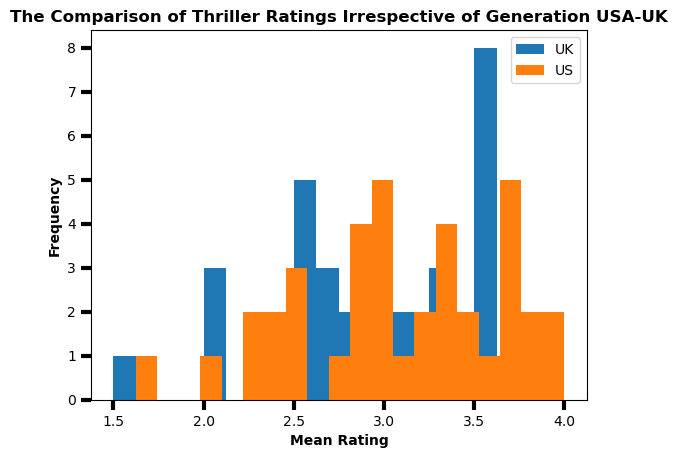

In [41]:
# comparing the mean rating of equivalent thrillers in the UK and US with all observed covariates removed from confounding country allocation
UK = balanced_thriller_us_uk[balanced_thriller_us_uk["countries"] == 0]
UK = UK["mean_rating"]

US = balanced_thriller_us_uk[balanced_thriller_us_uk["countries"] == 1]
US = US["mean_rating"]

print(UK.describe())
print(US.describe())

plt.hist(UK, bins=20, label = "UK")
plt.hist(US, bins=20, label = "US") 

plt.xlabel("Mean Rating", weight='bold')
plt.ylabel("Frequency", weight='bold')
plt.legend() 
plt.title("The Comparison of Thriller Ratings Irrespective of Generation USA-UK", weight='bold')
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.show()


There is only a slight increase in movie ratings in UK thriller movies, which could be caused by the film being released in the UK given all other observable covariates of the films were matched between the control = UK and treatment = US regions.

## Continental differences in Ratings

Now, ratings distribution in different countries are displayed and analysed.

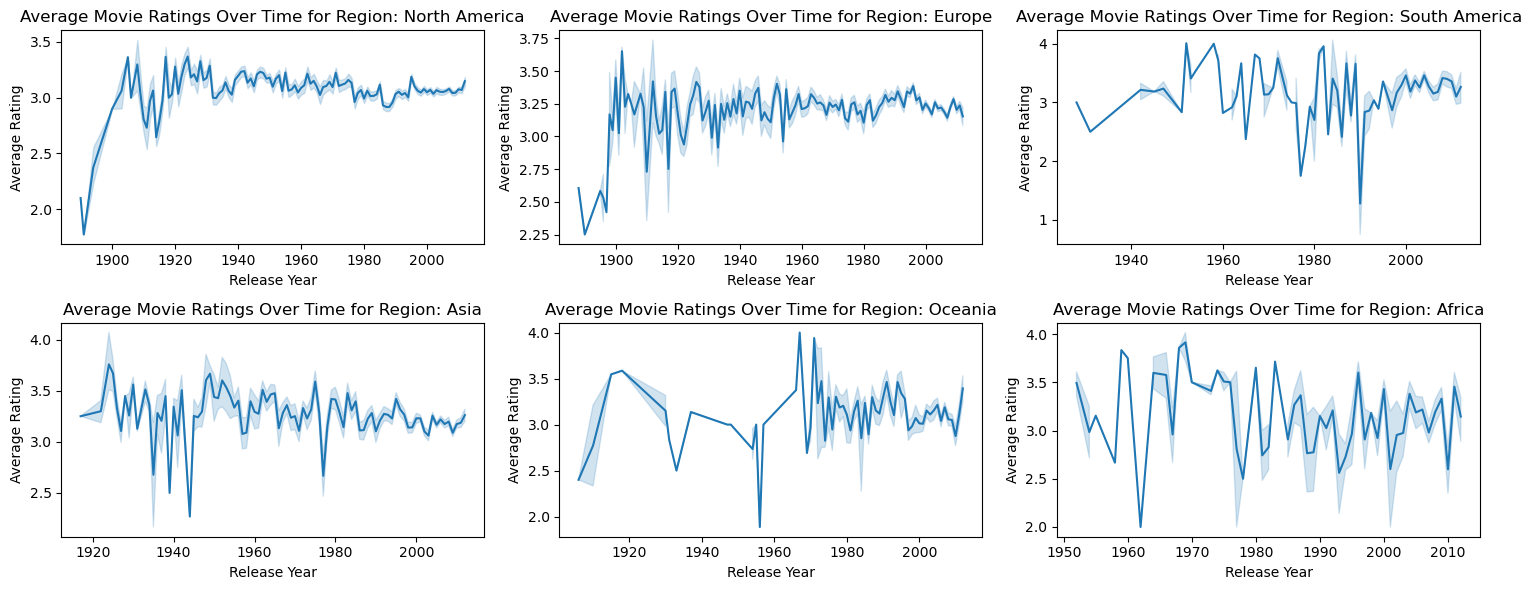

In [ ]:
# Plot the movies rating evolution between different continents
# Number of rows and columns for subplots
n_cols = 3
n_rows = 2

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,6))
axes = axes.flatten()

for i, continent in enumerate(continents):
    ax = axes[i] 
    ax.set_title(f"Average Movie Ratings Over Time for Region: {continent}")
    
    # continent filtering
    continent_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == continent]

    sns.lineplot(data=continent_movies, x='release_date', y='mean_rating', ax=ax,  estimator='mean', color='C0')
    
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Average Rating')


plt.tight_layout() 
plt.show()

From the above graphs, some irregularities can be seen, the plots are not smooth and the mean value is difficult to identify. But let's investigate the movie rating distribution within each continent.

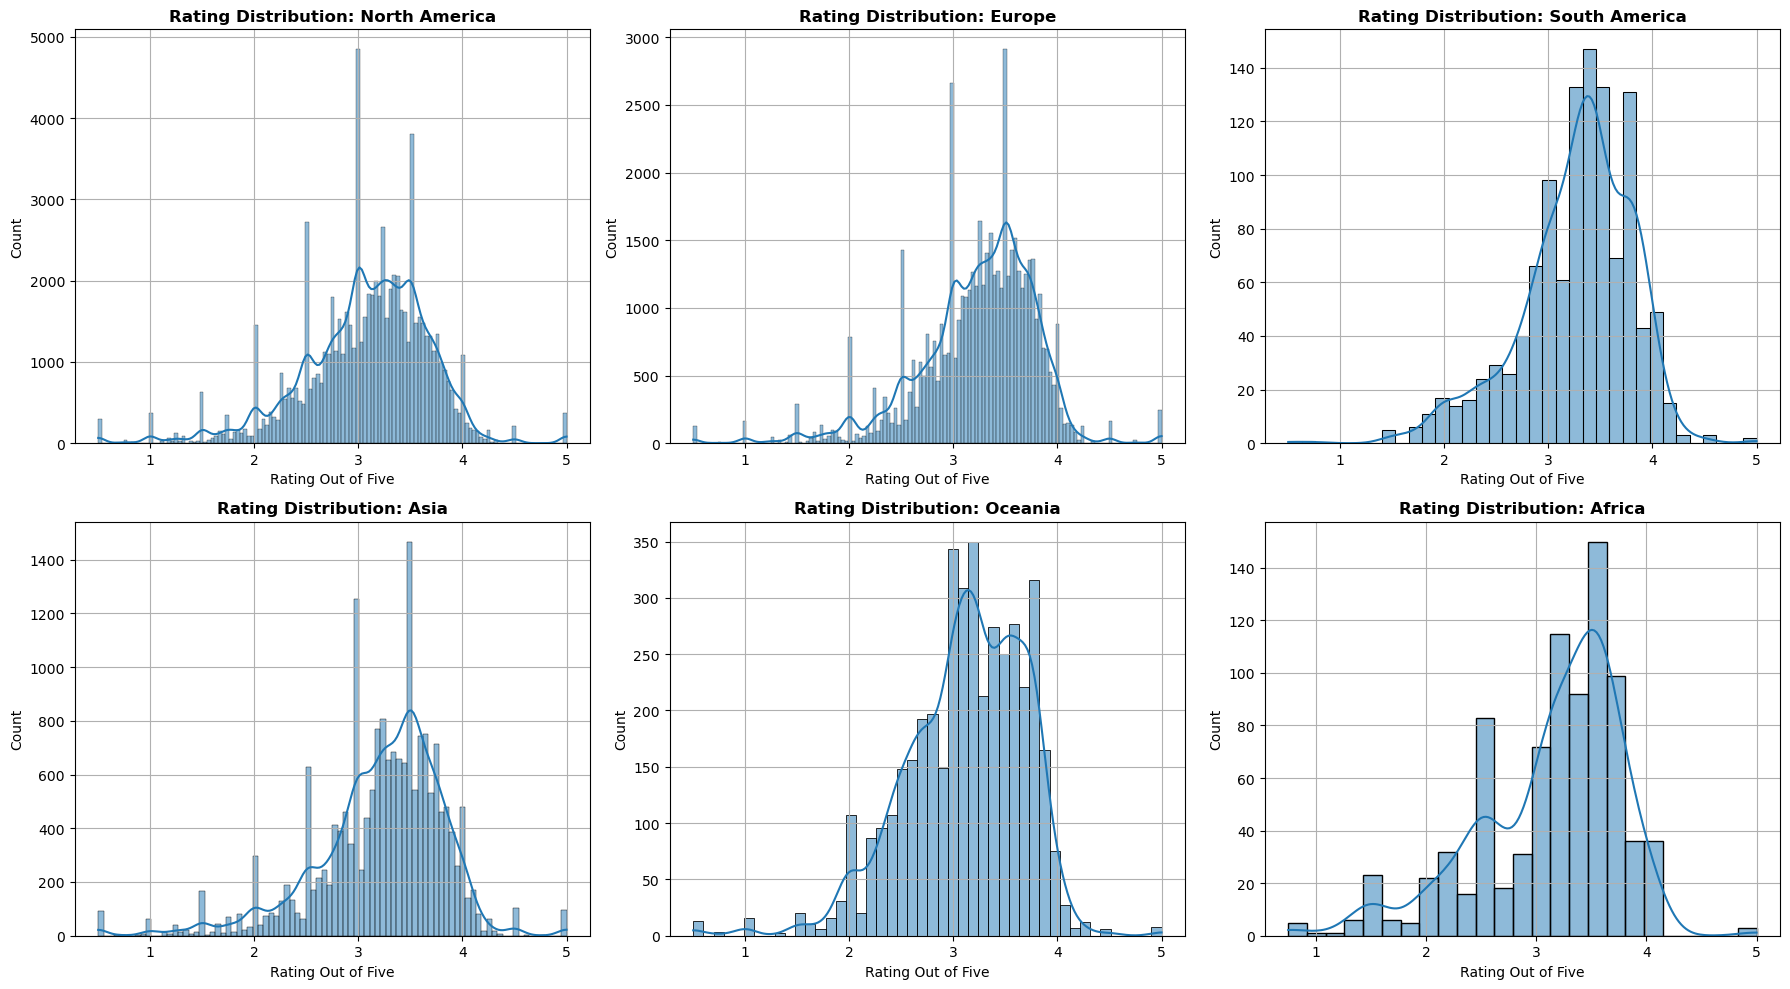

In [ ]:
n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

# For cycle to select continents
for i, continent in enumerate(continents):
    ax = axes[i]
    ax.set_title(f"Rating Distribution: {continent}", fontsize=12, weight='bold')
    
    # Filter by continent
    continent_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == continent]
    
    # Plot histograms
    sns.histplot(continent_movies['mean_rating'], kde=True, ax=ax)
    
    # Setting the axes
    ax.set_xlabel('Rating Out of Five', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.show()

From the above graphs, a normal distribution can be a realistic hypothesis for the distributions. Therefore, further tests are conducted.

In [84]:
# Check for normality of ratings by region
for continent in continents:
    region_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == continent]['mean_rating']
    p_value = stats.kstest(region_ratings, 'norm')[1]
    print(f"Normality test for {continent} ratings p-value: {p_value}")

Normality test for North America ratings p-value: 0.0
Normality test for Europe ratings p-value: 0.0
Normality test for South America ratings p-value: 0.0
Normality test for Asia ratings p-value: 0.0
Normality test for Oceania ratings p-value: 0.0
Normality test for Africa ratings p-value: 0.0


The p-values for normality tests across all regions (**p** = 0.0) suggest a significant deviation from normality in the ratings data. Given the large sample size, even minor deviations from normality will yield significant results, which is why the p-values are extremely low.
Despite these deviations, QQ plots might reveal more detailed insights into specific distribution features such as skewness or heavy tails.

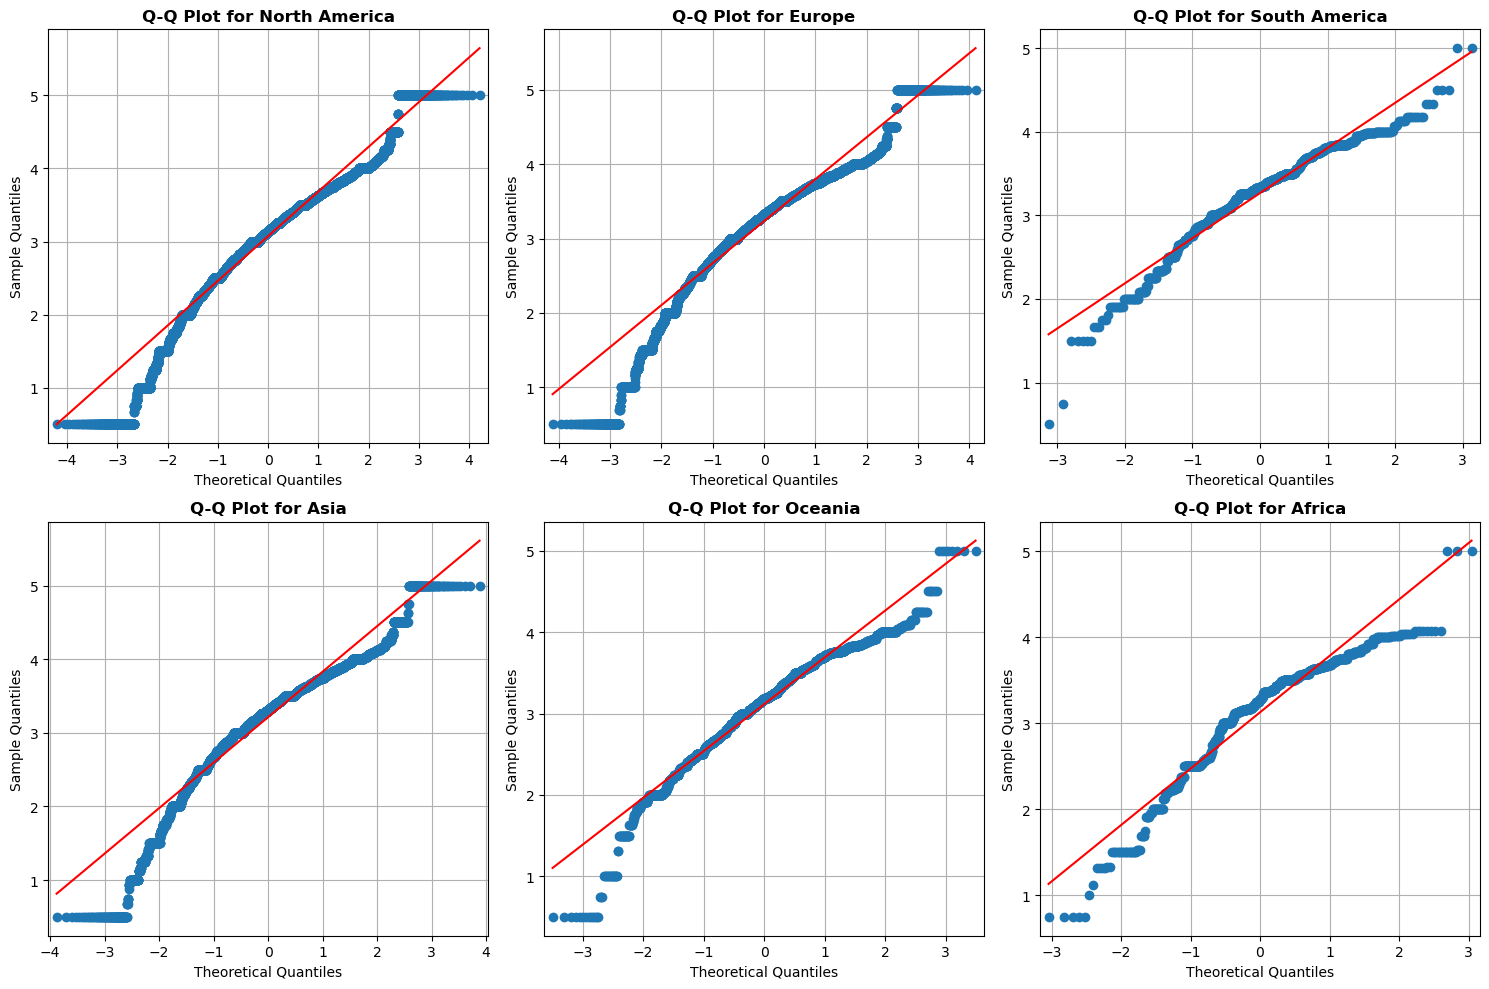

In [86]:
# Set up the layout for multiple Q-Q plots
plt.figure(figsize=(15, 10))
rows = (len(continents) + 2) // 3  

for i, continent in enumerate(continents, 1):
    plt.subplot(rows, 3, i)
    region_data = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == continent]['mean_rating']
    
    # Create Q-Q plot
    sm.qqplot(region_data, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot for {continent}', weight = 'bold')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

We observe left skewness and spikes of identical values

To deepen our analysis, the means are compared, using the t-test to compare ratings between North America and Europe

In [89]:
# Compare ratings between North America and Europe
na_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == 'North America']['mean_rating']
eu_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == 'Europe']['mean_rating']

# T-test
t_stat, p_value = stats.ttest_ind(na_ratings, eu_ratings)
print(f"T-test between North America and Europe ratings: t-stat = {t_stat}, p-value = {p_value}")

T-test between North America and Europe ratings: t-stat = -48.03704005436042, p-value = 0.0


t-statistic = -48.03 and p-value = 0.0 indicate a statistically significant difference in mean ratings between North America and Europe.
A large t-statistic and low p-value (p < 0.05) confirm that the mean ratings are distinct between these two regions.

To compare means, Linear regression can be used, where the baseline will be `North America`

In [90]:
# Encode region as a categorical variable
df_movies_tmdb_ratings['continent'] = pd.Categorical(df_movies_tmdb_ratings['continent'], categories=['North America'] 
                                                     + [cat for cat in df_movies_tmdb_ratings['continent'].unique() if cat != 'North America'])

# Fit the linear regression model
model = smf.ols('mean_rating ~ C(continent)', data=df_movies_tmdb_ratings)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     523.1
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:11:09   Log-Likelihood:            -1.4120e+05
No. Observations:              156838   AIC:                         2.824e+05
Df Residuals:                  156832   BIC:                         2.825e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

The OLS regression model, using North America as the baseline region (so the intercept represents the average rating for North America), yields an `R-squared` of **0.016**. This means that only **1.6%** of the variance in ratings is explained by region alone, indicating that region contributes minimally to rating differences. `South America` and `Europe` show the largest positive deviations from the North American baseline, with coefficients around **0.15-0.16**. This indicates that, on average, movies are rated approximately **0.15-0.16** points higher in these regions compared to North America. However, despite the low explained variance, the regional coefficients provide insights into small but statistically significant (**p <0.05**) differences.

The ANOVA test can be used, to support the findings.

In [93]:
# ANOVA to compare mean ratings across multiple regions
rating_groups = [df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == continent]['mean_rating'] for continent in continents]

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"ANOVA across regions: F-stat = {f_stat}, p-value = {p_value}")


ANOVA across regions: F-stat = 523.1490722694919, p-value = 0.0


The ANOVA test results (**F-statistic = 523.149**, **p-value = 0.0**) confirm that there are significant differences in mean ratings across different regions, supporting the findings from the t-test and regression.

## Prediction of Mean Ratings

With the code presented below, this analysis tries to find a meaningful way to predict the mean ratings, depending on other numerical attributes such as runtime, release date and revenue.

In [98]:
# Calculate Pearson's correlation between mean_rating and runtime
corr_runtime, p_value_runtime = stats.pearsonr(df_movies_tmdb_ratings_unique['mean_rating'], df_movies_tmdb_ratings_unique['runtime'])
print(f"Pearson correlation between Ratings and Runtime: corr = {corr_runtime}, p-value = {p_value_runtime}")


# Calculate Pearson's correlation between mean_rating and revenue
df_runtime_pearson = df_movies_tmdb_ratings_unique.dropna(subset=['revenue'])
corr_revenue, p_value_revenue = stats.pearsonr(df_runtime_pearson['mean_rating'], df_runtime_pearson['revenue'])
print(f"Pearson correlation between Ratings and Revenue: corr = {corr_revenue}, p-value = {p_value_revenue}")

# Calculate Pearson's correlation between mean_rating and year
corr_revenue, p_value_release_date = stats.pearsonr(df_movies_tmdb_ratings_unique['mean_rating'], df_movies_tmdb_ratings_unique['release_date'])
print(f"Pearson correlation between Ratings and Release_date: corr = {corr_revenue}, p-value = {p_value_release_date}")

Pearson correlation between Ratings and Runtime: corr = 0.154038187723771, p-value = 2.250152688730785e-124
Pearson correlation between Ratings and Revenue: corr = 0.08360269252322798, p-value = 5.298378899277511e-16
Pearson correlation between Ratings and Release_date: corr = -0.009094507810199784, p-value = 0.16389283878372188


Pearson correlations reveal:
`Runtime` has a weak positive correlation with ratings (**r = 0.15**), indicating that longer movies tend to have slightly higher ratings. To calculate Pearsons coefficient, all missing values in the revenue column had to be dropped. Therefore, the result depends only on the movies that had an entry for revenue (40% of the movies).
`Revenue` shows an even weaker positive correlation with ratings (**r = 0.05**), suggesting higher-rated movies are associated with slight revenue increases. 
`Release Date` has a near-zero negative correlation with ratings (**r = -0.009**), implying no meaningful relationship.

In [99]:
# Linear Regression to predict ratings based on movie attributes
mod = smf.ols(formula='mean_rating ~ release_date + runtime + revenue', data=df_movies_ratings_unique)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.12
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.30e-06
Time:                        19:34:28   Log-Likelihood:                -1739.5
No. Observations:                1940   AIC:                             3487.
Df Residuals:                    1936   BIC:                             3509.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.4430      1.267      3.506   

The model yields an **R-squared** of **0.015**, indicating that approximately **1.5%** of the variance in the average movie rating (mean_rating) is explained by the predictors—`release date`, `runtime`, and `revenue`. The low R-squared suggests that while these predictors have statistically significant effects, they do not account for much of the variance in ratings. These effects are the same that we found with Pearson correlation.

The predictors must be centered, by subtracting the mean.

In [100]:
# Center the predictors by subtracting the mean
df_movies_ratings_unique['release_date_centered'] = df_movies_ratings_unique['release_date'] - df_movies_ratings_unique['release_date'].mean()
df_movies_ratings_unique['runtime_centered'] = df_movies_ratings_unique['runtime'] - df_movies_ratings_unique['runtime'].mean()
df_movies_ratings_unique['revenue_centered'] = df_movies_ratings_unique['revenue'] - df_movies_ratings_unique['revenue'].mean()

# Now fit the model using the centered predictors
mod_centered = smf.ols(formula='mean_rating ~ release_date_centered + runtime_centered + revenue_centered', data=df_movies_ratings_unique)
res_centered = mod_centered.fit()

print(res_centered.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.12
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.30e-06
Time:                        19:36:37   Log-Likelihood:                -1739.5
No. Observations:                1940   AIC:                             3487.
Df Residuals:                    1936   BIC:                             3509.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.14

By centering, the `intercept` in this model is **3.1421**. By centering the predictors, this intercept now represents the expected mean rating when all predictor variables are at their respective means. This baseline is more interpretable in a real-world context compared to the uncentered model, as it reflects an average rating of **3.14** for movies with average release dates, runtimes, and revenues.

## Non-parametrical alternatives

To be sure of the obtained results, non-parametrical alternatives to the above tests can be used.

In [105]:
# Non-parametric test: Mann-Whitney U test (alternative to T-test)
na_ratings = df_movies_ratings_unique[df_movies_ratings_unique['continent'] == 'North America']['mean_rating']
eu_ratings = df_movies_ratings_unique[df_movies_ratings_unique['continent'] == 'Europe']['mean_rating']

# Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(na_ratings, eu_ratings)
print(f"Mann-Whitney U test between North America and Europe ratings: U-stat = {u_stat}, p-value = {p_value}")

# Non-parametric test: Kruskal-Wallis H test (alternative to ANOVA)
regions = df_movies_ratings_unique['continent'].unique()
rating_groups = [df_movies_ratings_unique[df_movies_ratings_unique['continent'] == continent]['mean_rating'] for continent in continents]

# Kruskal-Wallis H test
h_stat, p_value = stats.kruskal(*rating_groups)
print(f"Kruskal-Wallis test across regions: H-stat = {h_stat}, p-value = {p_value}")

# Non-parametric test: Spearman's rank correlation (alternative to Pearson's correlation)

# Calculate Spearman's rank correlation between mean_rating and runtime
corr_runtime, p_value_runtime = stats.spearmanr(df_movies_ratings_unique['mean_rating'], df_movies_ratings_unique['runtime'])
print(f"Spearman correlation between Ratings and Runtime: corr = {corr_runtime}, p-value = {p_value_runtime}")

# Calculate Spearman's rank correlation between mean_rating and revenue
corr_revenue, p_value_revenue = stats.spearmanr(df_runtime_pearson['mean_rating'], df_runtime_pearson['revenue'])
print(f"Spearman correlation between Ratings and Revenue: corr = {corr_revenue}, p-value = {p_value_revenue}")

# Calculate Spearman's rank correlation between mean_rating and release_date
corr_release_date, p_value_release_date = stats.spearmanr(df_movies_ratings_unique['mean_rating'], df_movies_ratings_unique['release_date'])
print(f"Spearman correlation between Ratings and Release_date: corr = {corr_release_date}, p-value = {p_value_release_date}")

Mann-Whitney U test between North America and Europe ratings: U-stat = 1521194.5, p-value = 0.00074199097442299
Kruskal-Wallis test across regions: H-stat = 22.535089200300575, p-value = 0.0004141166854062467
Spearman correlation between Ratings and Runtime: corr = 0.10732102445672777, p-value = 8.548310463017602e-13
Spearman correlation between Ratings and Revenue: corr = 0.03511893246037427, p-value = 0.0006750427993473793
Spearman correlation between Ratings and Release_date: corr = -0.01800883832455773, p-value = 0.23139603288561478


From these non-parametric tests, the same conclusions can be drawn.

## Box-Cox Transformation

The Box-Cox transformation was applied to stabilize variance and make the distribution closer to normal. Let us see if the obtained results are similar or different from the already analysed ones.

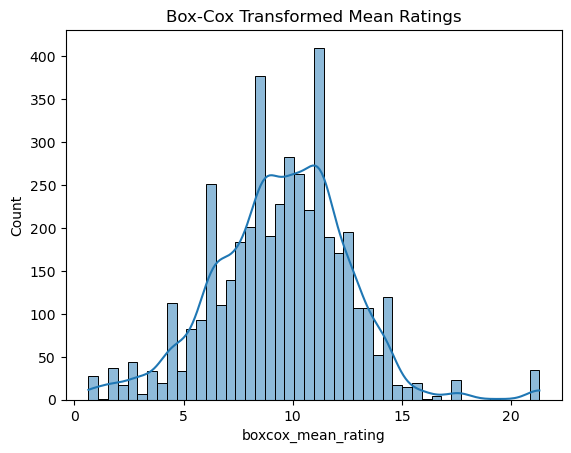

Normality test for Box-Cox transformed ratings p-value: 7.620644867400333e-24


In [102]:
# Box-Cox requires positive data, so ensure there are no zero or negative ratings
df_movies_ratings_unique['boxcox_mean_rating'], lambda_ = boxcox(df_movies_ratings_unique['mean_rating'] + 1)

# Check the distribution after Box-Cox transformation
sns.histplot(df_movies_ratings_unique['boxcox_mean_rating'], kde=True)
plt.title('Box-Cox Transformed Mean Ratings')
plt.show()

# Perform a normality test on the transformed data
stat, p_value = stats.shapiro(df_movies_ratings_unique['boxcox_mean_rating'])
print(f"Normality test for Box-Cox transformed ratings p-value: {p_value}")

Plot per continent the Box-Cox Transformation distribution.

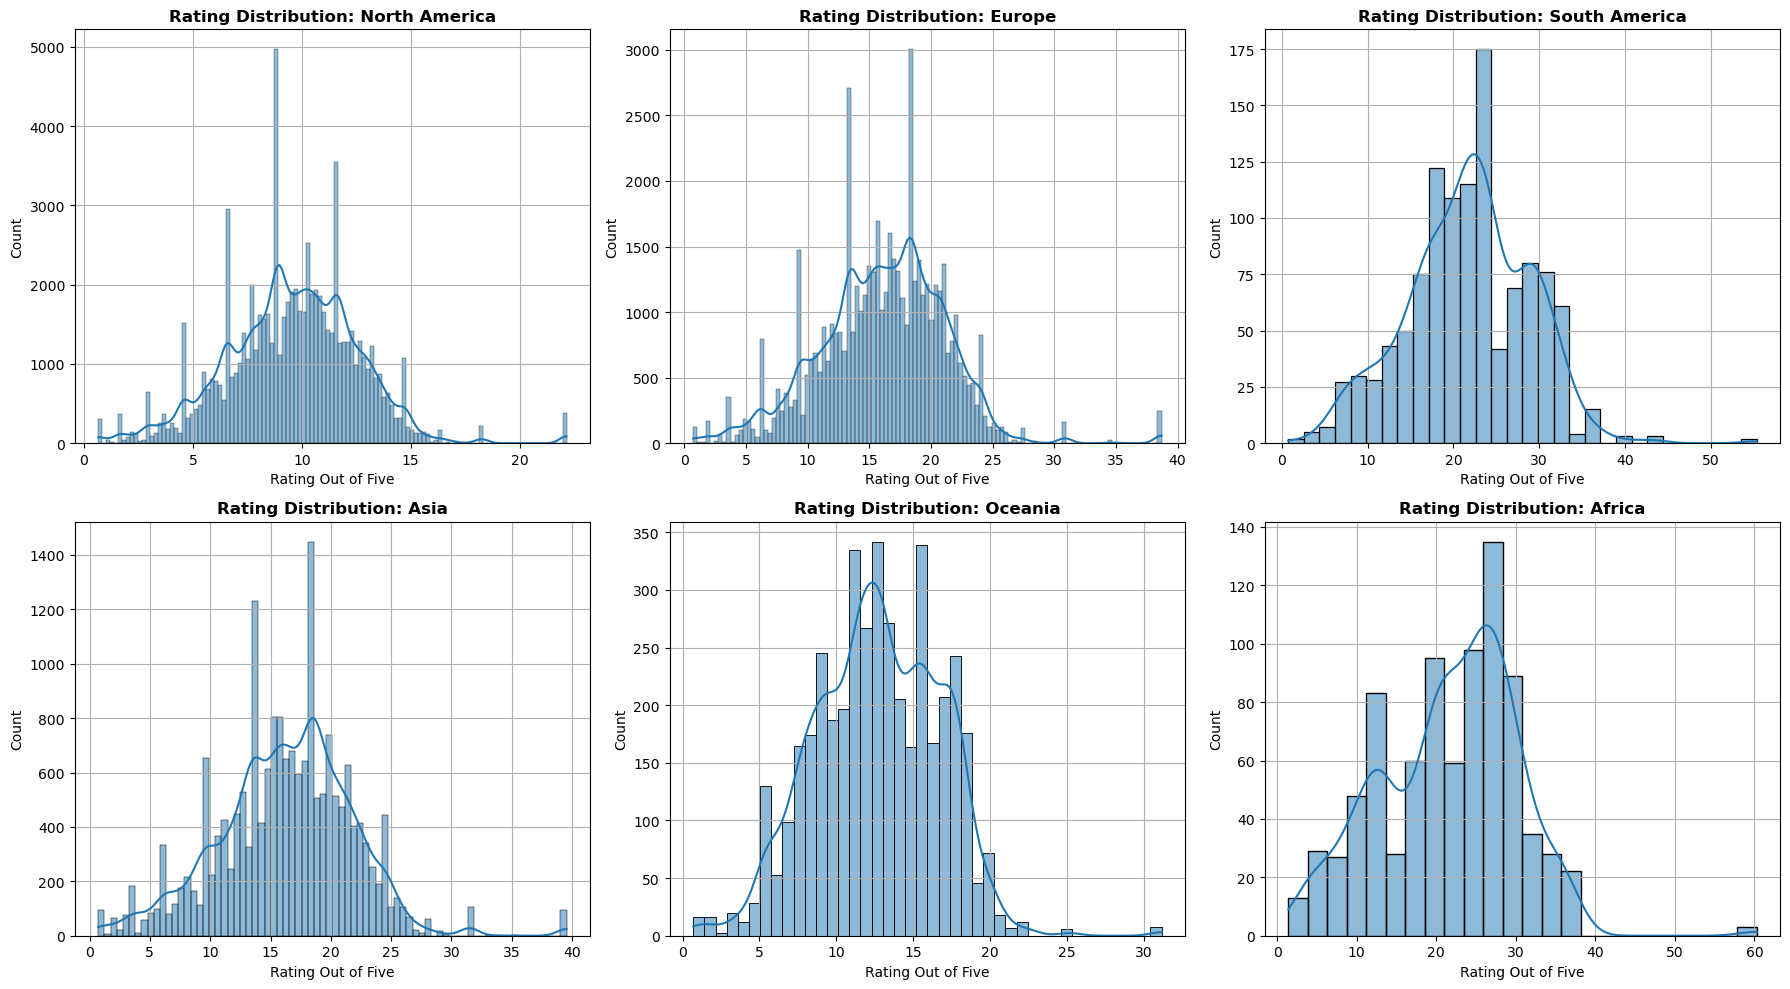

In [107]:
n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

# For cycle to select continents
for i, continent in enumerate(continents):
    ax = axes[i]
    ax.set_title(f"Rating Distribution: {continent}", fontsize=12, weight='bold')
    
    # Filter by continent
    continent_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'] == continent].copy()

    # Apply the Box-Cox transformation
    continent_movies['boxcox_mean_rating'], lambda_ = boxcox(continent_movies['mean_rating'] + 1)
    
    # Plot histograms
    sns.histplot(continent_movies['boxcox_mean_rating'], kde=True, ax=ax)
    
    # Setting the axes
    ax.set_xlabel('Rating Out of Five', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.show()

Despite this transformation, normality tests still yield very low p-values across all regions, indicating non-normality persists even after the transformation. `South America` is the only promising resulting transformation.

In [111]:
# Filter data for Latin America region
la_data = df_runtime_pearson[df_runtime_pearson['continent'] == 'South America'].copy()

# Ensure there are no zero or negative values, as Box-Cox requires positive values
la_data['mean_rating'] = la_data['mean_rating'] + 1  # To avoid zero/negative ratings

# Apply Box-Cox transformation to mean_rating
la_data['boxcox_mean_rating'], lambda_ = boxcox(la_data['mean_rating'])

# Define the independent variables (covariates) and dependent variable (Box-Cox transformed mean ratings)
X = la_data[['revenue', 'release_date', 'runtime']] 
y = la_data['boxcox_mean_rating']  

# Add a constant (intercept) to the model
X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     boxcox_mean_rating   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.090
Date:                Wed, 13 Nov 2024   Prob (F-statistic):              0.369
Time:                        19:51:38   Log-Likelihood:                -155.20
No. Observations:                  33   AIC:                             318.4
Df Residuals:                      29   BIC:                             324.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          295.5616    602.207      0.491   

In this Box-Cox-transformed model, `runtime` emerges as a significant positive predictor of movie ratings in South America, while `revenue` and `release date` show weaker or non-significant associations. The model explains a modest amount of variance, and further investigation may be needed to explore other variables that could better explain variations in movie ratings for this region.

## Time Series Analysis

Exploring the possibility of time related trends in ratings over time.

In [113]:
region_time_series = df_movies_ratings_unique.groupby(['release_date', 'continent'])['mean_rating'].mean().reset_index()
region_time_series = region_time_series.dropna(subset=['mean_rating'])

# Check the difference between consecutive release dates for each region
for continent in continents:
    region_data = region_time_series[region_time_series['continent'] == continent].sort_values(by='release_date')
    date_diff = region_data['release_date'].diff().dropna()
    print(f"Gaps for {continent}:")
    print(date_diff.describe())  # This will tell you the range of gaps between consecutive release dates


Gaps for North America:
count    103.000000
mean       1.009709
std        0.098533
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: release_date, dtype: float64
Gaps for Europe:
count    97.000000
mean      1.175258
std       0.763903
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       7.000000
Name: release_date, dtype: float64
Gaps for South America:
count    15.000000
mean      2.600000
std       3.018988
min       1.000000
25%       1.000000
50%       1.000000
75%       2.500000
max      11.000000
Name: release_date, dtype: float64
Gaps for Asia:
count    64.00000
mean      1.34375
std       1.25000
min       1.00000
25%       1.00000
50%       1.00000
75%       1.00000
max      10.00000
Name: release_date, dtype: float64
Gaps for Oceania:
count    30.000000
mean      2.700000
std       7.821941
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      44.000000
Na

The gaps are minimal for `Africa`, this is why we will preferably do the analysis on this continent.

In [117]:
# Conduct ADF test for each region, ordered by release_date
regions = region_time_series['continent'].unique()
adf_results = {}

for continent in continents:
    # Filter and sort by release_date to maintain time order
    region_data = region_time_series[region_time_series['continent'] == continent].sort_values(by='release_date')['mean_rating']
    adf_result = adfuller(region_data)  # Drop any NaN values for ADF test
    p_value = adf_result[1]
    adf_results[continent] = p_value
    print(f"ADF Test for {continent} - p-value: {p_value}")


ADF Test for North America - p-value: 0.013736292051035041
ADF Test for Europe - p-value: 0.03806003682859831
ADF Test for South America - p-value: 0.0026946973219234165
ADF Test for Asia - p-value: 6.891798197441124e-05
ADF Test for Oceania - p-value: 1.557736206409851e-10
ADF Test for Africa - p-value: 7.305543479939264e-26


Augmented Dickey-Fuller tests show low p-values for all regions, suggesting that the ratings are **stationary**, which means they do not follow a trend over time and are suitable for time series modeling without differencing.

# Characters Analysis, focused on ethnicities